# Aprendizaje Automático - Práctica 1 - Experimentación con clasificadores y regresores

#### Valoración máxima: 10 puntos

#### Fecha límite de entrega: 14 de Abril de 2024 a las 23:59

#### Entrega a través de https://pradogrado2324.ugr.es/

### Nombre completo: <mark>Elena Torres Fernández</mark>



---


**Normas de desarrollo y entrega de trabajos**

- Única y exclusivamente se debe entregar este Notebook de Colab (fichero `.ipynb`) o, en su defecto, tres Notebooks de Colab (uno con cada ejercicio). No es necesario entregar ninguna memoria externa (por ejemplo, en `.pdf`).

- El código debe estar bien comentado (explicando lo que realizan los distintos apartados y/o bloques), y todas las decisiones tomadas y el trabajo desarrollado (incluyendo los conceptos fundamentales subyacentes) deben documentarse ampliamente en celdas de texto. Es obligatorio documentar las valoraciones y decisiones adoptadas en el desarrollo de cada uno de los apartados. Debe incluirse también tanto una descripción de las principales funciones (Python/scikit-learn) empleadas (para mostrar que el alumno comprende, a nivel técnico, lo que está haciendo), como una valoración razonada sobre la calidad de los resultados obtenidos. Sin esta documentación, se considera que el trabajo NO ha sido presentado.

- La entrega en PRADO está configurada para permitir sucesivas entregas de la práctica. Desde este punto de vista, se recomienda subir versiones de la práctica a medida que se van realizando los distintos ejercicios propuestos, y no dejarlo todo para el final.  

- Se debe respetar la estructura y secciones del Notebook. Esto servirá para agilizar las correcciones, así como para identificar con facilidad qué ejercicio/apartado se está respondiendo.

- El código NO puede escribir nada a disco.

- El path de lectura desde Google Drive debe ser siempre el mismo, que es el que se indica en este Notebook.

- Una entrega es apta para ser corregida si se puede ejecutar de principio a fin sin errores. Es decir, un ejercicio con errores de ejecución tendrá una calificación de 0.

- No es válido usar opciones en las entradas (es decir, utilizar el comando `input()`, por ejemplo, para que el usuario escoja el valor de las variables para ejecutar el programa). Para ello, se deben fijar al comienzo los valores
por defecto que se consideren óptimos o que se soliciten en el enunciado.

- Se entrega solamente este Notebook, y no los datos empleados.


---

## <font color='blue'>Ejercicio 1: EL PROBLEMA DEL SOBREAJUSTE (2 puntos)</font>

<font color='blue'>Aprendizaje Automático (AA) es la rama de la Inteligencia Artificial (IA) que se ocupa de diseñar e implementar máquinas que sean capaces de aprender a realizar una determinada tarea a partir de los propios datos (es decir, sin necesidad de ser programadas explícitamente para ello). El principal objetivo de los modelos de AA es realizar predicciones/estimaciones más allá de los conjuntos de datos con los que fueron entrenados y, como es lógico, se pretende que dichos modelos sean capaces de $generalizar$ más allá de los ejemplos vistos en entrenamiento. Como consecuencia, uno de los mayores obstáculos a los que nos enfrentamos se conoce como $sobreajuste$ ($overfitting$): el hecho de que nuestros pesos/parámetros estén demasiado apegados a nuestros ejemplos de entrenamiento, y se produzca una brecha a nivel de generalización (en donde los resultados en entrenamiento serían manifiestamente mejores que en test).

<font color='blue'>En este ejercicio intentaremos profundizar un poco en lo que es el sobreajuste, así como las causas y consecuencias del mismo.



---




<font color='blue'>Primero, importamos las librerías necesarias y fijamos la semilla aleatoria para que nuestros resultados sean reproducibles entre ejecuciones.


In [ ]:
# módulos necesarios para todo el documento
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, ParameterGrid, RepeatedKFold, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

from tabulate import tabulate
import pandas as pd
import seaborn as sns
from joblib import cpu_count

# Fijamos la semilla aleatoria
np.random.seed(42) #¿Por qué 42? https://en.wikipedia.org/wiki/Phrases_from_The_Hitchhiker%27s_Guide_to_the_Galaxy

In [ ]:
import sklearn
if sklearn.__version__ < '1.3':
  # Actualizamos scikit-learn para tener la última versión.
  # Nos interesa de cara a disponer de las más recientes funcionalidades
  # (como, por ejemplo, poder usar cross_validate() empleando el parámetros return_indices=True; https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
  !pip install scikit-learn --upgrade
else:
  print('La versión de scikit-learn es: ', sklearn.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2






---






### <font color='blue'>Ejercicio 1.A: Regresión en 1D (1 punto)</font>

<font color='blue'> En este ejercicio se intentará aproximar una función continua unidimensional por medio de regresión lineal (`LinearRegression()`), y se irá, progresivamente, incrementando la complejidad del modelo empleando características polinomiales (`PolynomialFeatures()`), de grados $\{1, 2, 4, 8, 16, 32\}$. La función real a aproximar (nuestra $\textit{ground truth}$) es: $f(x) = cos(1.5\cdot\pi\cdot x) + sin(0.5\cdot\pi\cdot x)$.

<font color='blue'> Las tareas a realizar en este ejercicio se resumen a continuación:
1.   Completamos el código de la función real a aproximar.
2.   Generamos las entradas ($X$): 20 puntos aleatorios en el intervalo $[0,1]$.
3.   Generamos las salidas deseadas ($y$): el valor resultante de emplear la función real y sumarle un cierto error aleatorio (`np.random.randn`: distribución Normal estándar), que pretende simular el ruido que pueden contener las etiquetas ($labels$/$targets$) en cualquier problema.
4.   Generamos las características polinomiales asociadas con los grados proporcionados, y creamos un $pipeline$ (usando `Pipeline` o `make_pipeline`) con dichas características y regresión lineal.
5.   Realizamos el ajuste (`fit`) de dicho `pipeline` con $X$ e $y$, y empleamos `cross_val_score`, o `cross_validate`, para evaluar el rendimiento utilizando $\textit{10-fold cross-validation}$ y el error cuadrático medio ($MSE$) como métrica de error.
6. Mostramos figuras con ajustes. Para ello, generamos 1000 valores equiespaciados en el intervalo $[0,1]$, y realizamos la predicción de nuestro modelo (`pipeline.predict`) sobre dichos datos para mostrar, en rojo, la función que aproxima nuestro modelo entrenado. En la misma figura incluiremos, en azul, la función real empleada para generar los datos, y los puntos/muestras generadas ($X$ e $y$). El título de cada figura debe incluir el grado del polinomio.
7. Junto con estas figuras, se debe mostrar una tabla (y aquí la librería `tabulate` puede ser de utilidad) que incluya, el grado del polinomio en la primera fila ($header$ de la tabla), el número de pesos/coeficientes en la segunda, el $MSE$ (promedio y desviación típica) obtenido en entrenamiento en validación cruzada en la tercera fila, el $MSE$ (promedio y desviación típica) obtenido en test en validación cruzada en la cuarta fila, y el valor medio de los coeficientes aprendidos en valor absoluto con cada uno de los 6 modelos ajustados (incluyendo el $bias$ o $intercept$) en la última.

<font color='blue'> El alumnado debe describir en detalle el trabajo realizado y las conclusiones extraídas: ¿se observa algún patrón en los resultados obtenidos, así como en la magnitud de los coeficientes tras el entrenamiento? ¿Se observa algún fenómeno de infraentrenamiento ($underfitting$) o sobreentrenamiento ($overfitting$)? ¿Qué grado considera el más adecuado para resolver este problema? ¿Por qué?

----------------------------  -----------------------
Grado polinomio               1
Número pesos                  2
MSE train                     1.58e-01 (+/- 3.98e-01)
MSE test                      2.23e-01 (+/- 4.72e-01)
Valor medio pesos (con bias)  0.42285570865774774
----------------------------  -----------------------
----------------------------  -----------------------
Grado polinomio               2
Número pesos                  3
MSE train                     5.12e-02 (+/- 2.26e-01)
MSE test                      8.72e-02 (+/- 2.95e-01)
Valor medio pesos (con bias)  0.2800006408464437
----------------------------  -----------------------
----------------------------  -----------------------
Grado polinomio               4
Número pesos                  5
MSE train                     5.45e-03 (+/- 7.38e-02)
MSE test                      7.77e-03 (+/- 8.81e-02)
Valor medio pesos (con bias)  0.039745651633264246
----------------------------  -----------------------
----------

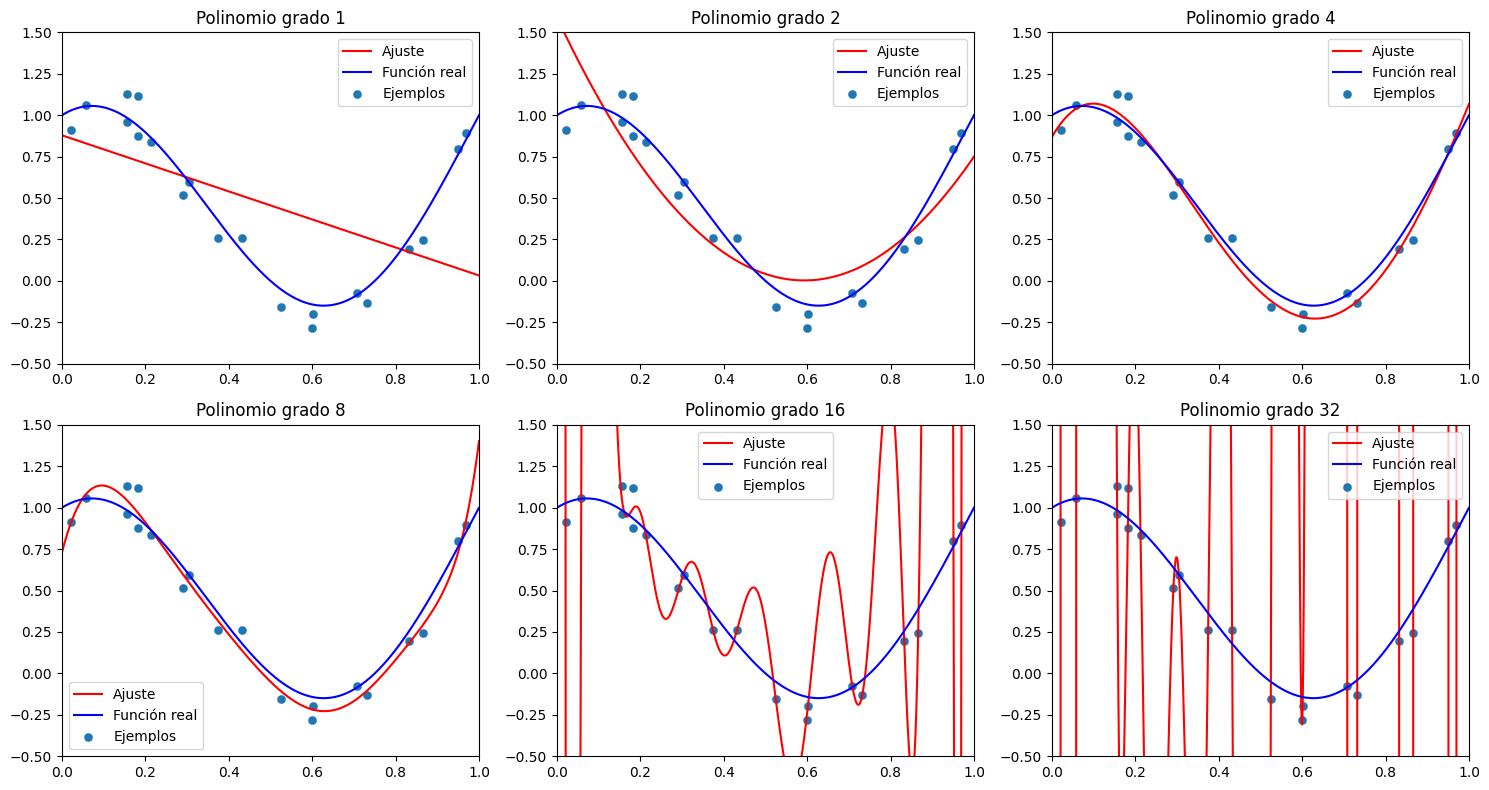

In [ ]:
# función real a aproximar
def funcionReal(X):
    return ( np.cos(1.5*np.pi*X) + np.sin(0.5*np.pi*X) )

# generamos datos de entrenamiento y sus etiquetas esperadas
n_samples = 20
X = np.random.rand(n_samples)
y = funcionReal(X) + np.random.randn(n_samples) * 0.1

# empleamos regresión lineal con distintas transf polinomiales de las caract de entrada
degrees = [1, 2, 4, 8, 16, 32]
mse_train = []
mse_test = []

plt.figure(figsize=(15, 8))

for i in range(len(degrees)):

    # creamos el pipeline y lo ajustamos con los datos de entrenamiento
    poly = PolynomialFeatures(degree=degrees[i], include_bias=True)
    regressor = LinearRegression()
    pipe = Pipeline( [("polynomial_features", poly), ("linear_regression", regressor)] )
    pipe.fit(X[:, np.newaxis], y)

    # evaluamos el modelo con cross-validation con los datos de entrenamiento
    scores = cross_validate( pipe, X[:, np.newaxis], y, scoring="neg_mean_squared_error", return_train_score=True, cv=10)
    mse_train.append(abs(np.mean(scores.get('train_score'))))
    mse_test.append(abs(np.mean(scores.get('test_score' ))))

    # generamos los datos de prueba
    X_test = np.linspace(0, 1, 1000)
    y_pred = pipe.predict(X_test[:, np.newaxis])

    # representamos una gráfica por polinomio para ver su ajuste a la función real
    ax = plt.subplot(2, len(degrees)//2, i+1)
    plt.plot(X_test, y_pred, 'r', label="Ajuste")                     # ajuste con datos de test (rojo)
    plt.plot(X_test, funcionReal(X_test), 'b', label="Función real")  # función real para los datos de test (azul)
    plt.scatter(X, y, linewidths=0.2, label="Ejemplos")               # ptos de entrenamiento (muestras)
    plt.xlim((0, 1))
    plt.ylim((-0.5, 1.5))
    plt.legend(loc="best")
    plt.title("Polinomio grado {0}".format(degrees[i]))

    # generamos una tabla con los resultados obtenidos para cada grado
    num_pesos = np.size(regressor.coef_)
    media_abs = abs((np.sum(regressor.coef_)) / (1.0*num_pesos))

    table = [["Grado polinomio", degrees[i]],
             ["Número pesos", num_pesos],
             ["MSE train", "{:.2e} (+/- {:.2e})".format(mse_train[i], np.sqrt(mse_train[i]))],
             ["MSE test", "{:.2e} (+/- {:.2e})".format(mse_test[i], np.sqrt(mse_test[i]))],
             ["Valor medio pesos (con bias)", media_abs] ]

    print(tabulate(table))

plt.tight_layout() # dejamos espacio entre figuras
plt.show()         # mostramos las gráficas

####Análisis de los resultados: <br>
En primer lugar, llama la atención cómo el <b>"MSE train"</b> va disminuyendo conforme aumenta el grado del polinomio, llegando a variar en 7 órdenes; mientras que el <b>"MSE test"</b> va aumentando considerablemente pasando de orden e-10 a e+15. Esta evolución inversamente proporcional la podemos observar en la gráfica de la siguiente celda. También cabe destacar cómo la <b>magnitud de los pesos</b> aumenta considerablemente a partir del grado 16 y 32, lo cual hace más trabajoso el cálculo computacional.

Viendo las gráficas, observamos que se produce <b><i>underfitting</i></b> cuando aproximamos con polinomios de grado 1 y 2, ya que la gráfica roja no llega a parecerse lo suficiente al comportamiento de la gráfica azul. Además, se obtienen valores de MSE y desviación típica parecidos tanto en el entrenamiento como en el testeo, característica propia del infraentrenamiento.

Con grados 4 y 8, vemos en las gráficas que el polinomio sí se ajusta bastante bien a los datos y fijándonos en las tablas podemos decidir cuál de ellos es mejor. <b>Me decantaría por usar el de grado 4</b> porque, aunque ambos tienen un MSE train parecido, el de menor grado obtiene un MSE test más bajo, lo que nos indica que el modelo de grado 4 generaliza mejor.

Por otro lado, con grados 16 y 32 se produce un claro <b><i>overfitting</i></b>: los datos de entrenamiento están bastante bien ajustados con un MSE train del orden de ~e-04 (vemos que la línea roja pasa por prácticamente todos los puntos de entrenamiento en ambos casos); mientras que con los datos de test se obtiene un MSE bastante malo, llegando a ser de orden ~e+15 para el caso de grado 32. Además, la desviación típica es muy alta en los datos de test, mostrando cómo el modelo es muy sensible a pequeñas variaciones respecto a los datos de entrenamiento. Comprobamos así, que el modelo no generaliza nada bien para estos grados.

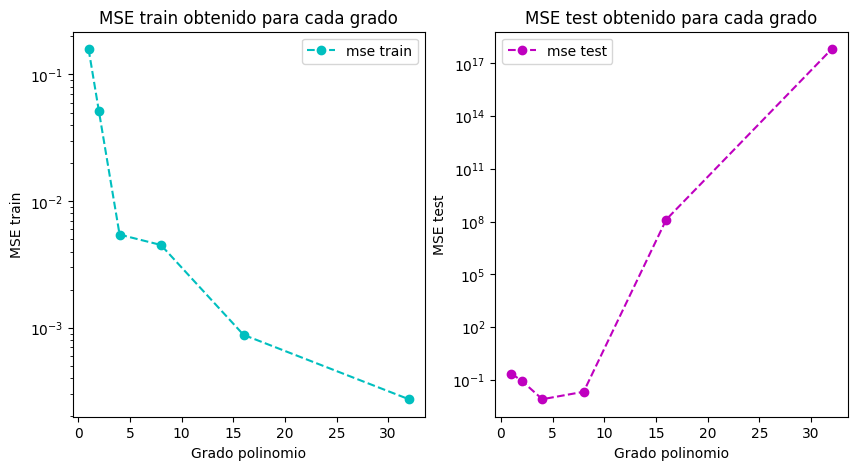

In [ ]:
# gráficas en escala logarítmica para visualizar la evolución del MSE train y test conforme aumenta el grado del polinomio
plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 2, 1)
plt.plot(degrees, mse_train, 'c--o', label="mse train")
plt.yscale("log")
plt.xlabel("Grado polinomio")
plt.ylabel("MSE train")
plt.title("MSE train obtenido para cada grado")
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(degrees, mse_test, 'm--o', label="mse test")
plt.yscale("log")
plt.xlabel("Grado polinomio")
plt.ylabel("MSE test")
plt.title("MSE test obtenido para cada grado")
plt.legend();

### <font color='blue'>Ejercicio 1.B: Clasificación en 2D (1 punto)</font>

<font color='blue'> En este ejercicio haremos algo similar a lo realizado en el anterior, pero ahora con un problema de clasificación y empleando un problema sintético en 2D. Haremos uso de dos funciones, que se incluyen a continuación:

<font color='blue'>$simula\_unif(N, dim, rango)$, que calcula una lista de $N$ vectores de dimensión $dim$. Cada vector contiene $dim$ números aleatorios uniformes en el intervalo $rango$.

<font color='blue'>$simula\_recta(intervalo)$, que simula de forma aleatoria los parámetros $v = (a, b)$ de una
recta, $y = ax + b$, dado un determinado intervalo (dentro del cual se generan dos puntos aleatorios, que se emplearán para calcular la pendiente y el término independiente de la recta).

In [ ]:
def simula_unif(N, dim, rango):
	return np.random.uniform(rango[0],rango[1],(N,dim))

In [ ]:
def simula_recta(intervalo):
    points = np.random.uniform(intervalo[0], intervalo[1], size=(2, 2))
    x1 = points[0,0]
    x2 = points[1,0]
    y1 = points[0,1]
    y2 = points[1,1]
    # y = a*x + b
    a = (y2-y1)/(x2-x1) # Cálculo de la pendiente.
    b = y1 - a*x1       # Cálculo del termino independiente.

    return a, b


<font color='blue'>Ahora, con ayuda de la función $simula\_unif()$, vamos a generar una muestra de 100 puntos 2D, en el intervalo $[-50, 50]$,  a los que vamos a añadir una etiqueta usando el signo de la función $f(x, y) = y - ax - b$ (es decir, el signo de la distancia de cada punto a la recta simulada con
$simula\_recta()$).




In [ ]:
"""
np.sign(0) da 0 (véase https://numpy.org/doc/stable/reference/generated/numpy.sign.html), lo que, en ciertas ocasiones, puede ser problemático
Por ese motivo, proporcionamos esta sencilla función que devuelve el signo del valor que se le proporciona como entrada
Si esta función se emplea con un array, se obtendrá el error "ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()"
Si quiere emplearse con arrays, bastaría vectorizarla:
		numeros = np.random.randint(-10,10,10)
		sgn = np.vectorize(signo)
		print(numeros)
		print(sgn(numeros))
"""
def signo(x):
	if x >= 0:
		return 1
	return -1

def f(x, y, a, b):
	return signo(y - a*x - b)

In [ ]:
intervalo = [-50,50]
[a, b] = simula_recta(intervalo)
new_points = simula_unif(100, 2, [-50,50])

y = []
for i in range(0,new_points.shape[0]):
    y.append(f(new_points[i][0], new_points[i][1], a, b))

y = np.array(y, np.float64)

<font color='blue'>A continuación, calculamos el error de clasificación de dicha recta ideal, y visualizamos el ajuste obtenido. Como es lógico, el error es 0% dado que lo único que estamos haciendo es mostrar los puntos etiquedatos con la recta que acabamos de crear.

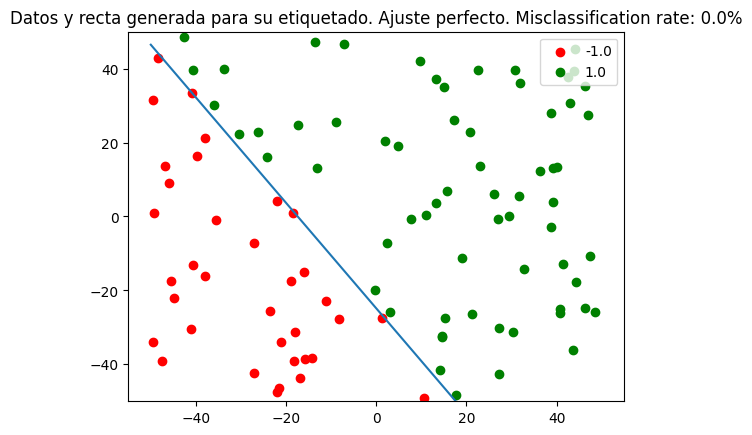

In [ ]:
errors = []
for i in range(0,new_points.shape[0]):
    errors.append(f(new_points[i,0], new_points[i,1], a, b) != y[i])
MC_rate = 100*np.sum(errors)/new_points.shape[0]

# Dibujamos una gráfica donde los puntos muestren el resultado de su etiqueta, junto con la recta usada para ello
clases = np.unique(y)
X_class = [new_points[y==c_i] for c_i in clases]
colors=['red','green']
for i in range(len(clases)):
    plt.scatter(X_class[i][:, 0], X_class[i][:, 1], color=colors[i], label = clases[i]) # representa los puntos

# plt.scatter(new_points[:,0],new_points[:,1], c=y)
plt.legend(loc='upper right')
plt.plot([intervalo[0], intervalo[1]], [a*(intervalo[0])+b, a*(intervalo[1])+b]) # representa la recta
plt.ylim((intervalo[0], intervalo[1]))
plt.title('Datos y recta generada para su etiquetado. Ajuste perfecto. Misclassification rate: {}%'.format(MC_rate))
plt.show()

<font color='blue'>Vamos a modificar de forma aleatoria un 5\% de las etiquetas positivas y otro 5\% de las negativas. Esta modificación de etiquetas está asociada con el ruido que siempre puede estar presenta en las etiquetas (sea por problemas en la transmisión de los datos, la precisión de los sistemas de medición, la incertidumbre ligada al proceso de adquisición y anotación de los datos, etc.) En esta ocasión, a pesar de que la recta empleada es la recta ideal (es decir, la propia función empleada para generar nuestra muestra original), habrá un cierto porcentaje de error asociado.  </font>

In [ ]:
def introducir_ruido(y,porcent_ruido):
  # Identificamos las clases a partir de las etiquetas
  classes = np.unique(y)
  # Creamos una copia de las etiquetas, que será el array ruidoso que produciremos como salida
  y_noise = y.copy()
  # Ahora vamos recorriendo cada una de las clases
  for i in range(len(classes)):
    # Calculamos el número de ejemplos por clase a modificar
    numberPerClass = int(np.round(np.sum(y==classes[i])*porcent_ruido/100))
    # Recuperamos los índices de los ejemplos de cada clase y los desordenamos
    clase = np.where(y == classes[i])
    clase = np.random.permutation(clase[0])
    # Alteramos (introducimos ruido en) los índices correspondientes
    for i in clase[:numberPerClass]:
      y_noise[i] = y[i]*-1

  return y_noise

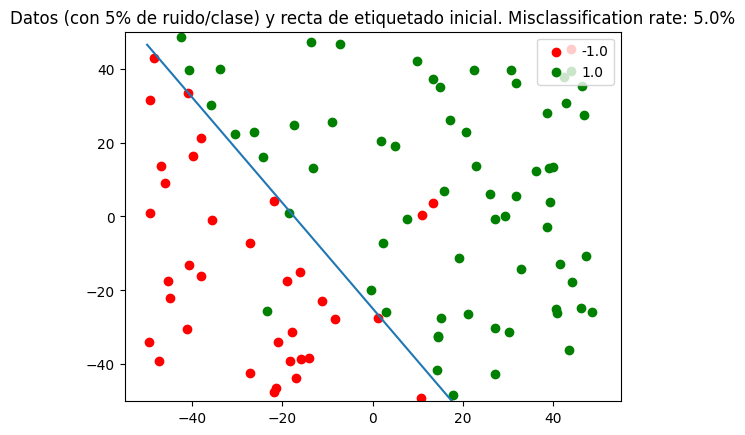

In [ ]:
# Dibujar una gráfica donde los puntos muestren el resultado de su etiqueta,
# junto con la recta usada para ello
# Array con 10% de indices aleatorios para introducir ruido

porcentaje_ruido = 5
y_noise = introducir_ruido(y,porcentaje_ruido)

errors = []
for i in range(0,new_points.shape[0]):
    errors.append(f(new_points[i,0], new_points[i,1], a, b) != y_noise[i])
MC_rate = 100*np.sum(errors)/new_points.shape[0]

plt.figure()

clases = np.unique(y_noise)
X_class = [new_points[y_noise==c_i] for c_i in clases]
colors=['red','green']
for i in range(len(clases)):
    plt.scatter(X_class[i][:, 0], X_class[i][:, 1], color=colors[i], label = clases[i]) # dibujamos los puntos

plt.legend(loc='upper right')
# plt.scatter(new_points[:,0],new_points[:,1], c=y_noise)
plt.plot([intervalo[0], intervalo[1]], [a*(intervalo[0])+b, a*(intervalo[1])+b]) # dibujamos la recta
plt.ylim((intervalo[0], intervalo[1]))
plt.title('Datos (con {}% de ruido/clase) y recta de etiquetado inicial. Misclassification rate: {}%'.format(porcentaje_ruido,MC_rate))
plt.show()



<font color='blue'>Ahora queremos entrenar un $\textit{Support Vector Machine}$
 (`sklearn.svm.SVC` con kernel lineal) con estos datos y mostrar $accuracy$ y $f1$-$score$, tanto en entrenamiento como test, así como las fronteras de decisión encontradas. Una frontera de decisión ($\textit{decision boundary}$) es la superficie/hiperplano que separa el espacio de entradas de modo que, en el contexto de un problema de clasificación binaria como el que nos ocupa, el clasificador etiquete todos los puntos de un lado de la frontera como pertenecientes a una clase y todos los del otro lado como pertenecientes a la otra.

 <font color='blue'>Vamos a repetir la operación anterior con distintas transformaciones (polinómicas) de los datos de entrada (grados $1, 2, 4$ y $8$). Queremos explorar cómo cambian estas fronteras de decisión a medida que incrementamos la complejidad de los modelos empleados.

 <font color='blue'> Más concretamente, tenemos que mostrar los siguientes resultados:
* <font color='blue'>Fronteras de decisión 2D sobre datos de entrenamiento para cada uno de los 4 ajustes (e incluyendo una línea que represente la frontera ideal, es decir, la correspondiente con la recta generadora de las etiquetas y que nos gustaría aproximar). Para esta visualización pueden resultar de utilidad las siguientes funciones: `contourf`, `ListedColormap` o `DecisionBoundaryDisplay`; y el siguiente script: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html.
* <font color='blue'>Una tabla que incluya el grado de polinomio empleado (en la primera fila), el número de pesos ajustados (en la segunda fila), y los errores de entrenamiento y test con cada uno de los modelos ajustados ($accuracy$ y $f1$-$score$), en las filas tercera y cuarta de la tabla, respectivamente. De cara a evaluar el error de test, en este caso crearemos un conjunto de test diferenciado (con 100 ejemplos) siguiendo exactamente el mismo proceso empleado para el conjunto de entrenamiento. Este error de test se utilizará como estimación del error fuera de la muestra (lo que se conoce como $\textit{out-of-sample error}$).

<font color='blue'>Desde el punto de vista de entrenamiento del modelo, se recomienda emplear $SVC$ atendiendo a los siguientes aspectos: es importante escalar los datos antes de entrenar (`StandardScaler`); no nos interesa emplear regularización a la hora de entrenar el modelo (¿por qué?), motivo por el cual tendremos que escoger un valor elevado para el hiperparámetro $C$; tendremos que escoger un valor de iteraciones suficientemente alto como para permitir que el modelo entrene adecuadamente, pero suficientemente bajo como para que el entrenamiento no se eternice; y, finalmente, recordemos que el kernel a emplear es linear (¿cuál emplea SVC por defecto?).

<font color='blue'>El alumnado debe describir en detalle el trabajo realizado, las decisiones tomadas, así como las conclusiones extraídas a partir de los resultados obtenidos.

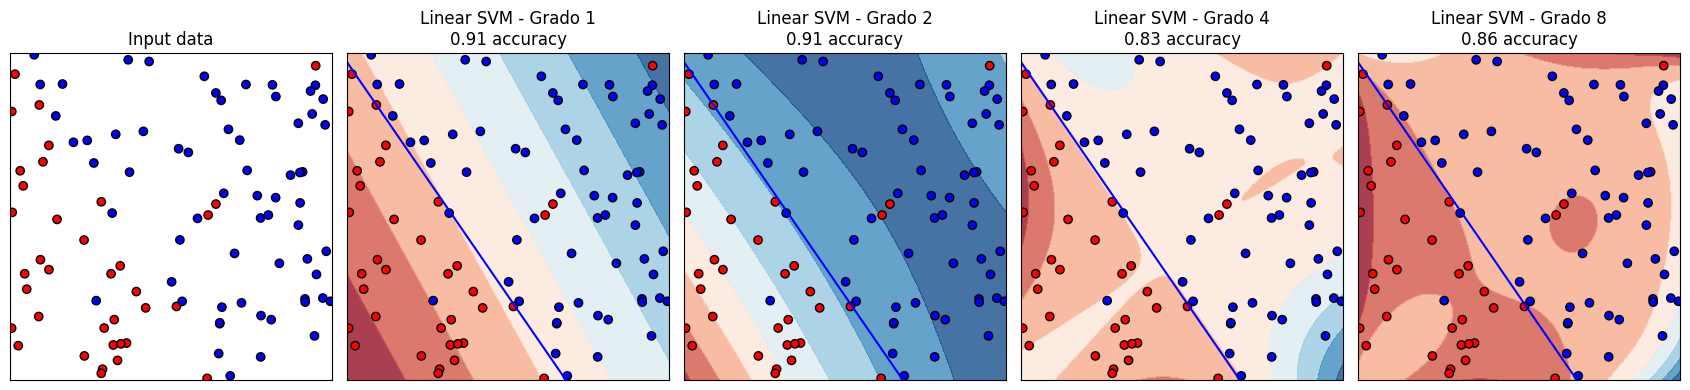

----------------------------  --------  --------  ---------  ---------
Grado polinomio               1         2          4          8
Número pesos                  3         6         15         45
Precisión media train         0.9175    0.93       0.9925     1
Precisión media test          0.91      0.91       0.83       0.86
F1 media train                0.936574  0.947303   0.994136   1
F1 media test                 0.929704  0.932153   0.860742   0.888748
Out-of-sample error accuracy  0.98      0.93       0.94       0.94
Out-of-sample error f1-score  0.985714  0.949206   0.954922   0.954393
----------------------------  --------  --------  ---------  ---------


In [ ]:
figure = plt.figure(figsize=(17,4))
degrees = [1, 2, 4, 8]

# dibujamos el CONJUNTO DE ENTRENAMIENTO en una primera gráfica titulada "Input data"
# los datos de la clase 1 son rojos y los de la clase 2, azules
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

ax = plt.subplot(1, len(degrees)+1, 1)
ax.set_title("Input data")
ax.scatter( new_points[:, 0], new_points[:, 1], c=y_noise, cmap=cm_bright, edgecolors="k")

x_min, x_max = new_points[:, 0].min() - 0.5, new_points[:, 0].max() + 0.5
y_min, y_max = new_points[:, 1].min() - 0.5, new_points[:, 1].max() + 0.5
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

# creamos nuevo CONJUNTO DE TEST para el out-of-sample error (error de generalización):
gen_points = simula_unif(100, 2, [-50,50])

# para asegurarnos que new_points y gen_points no tienen ptos en común
for pto in range(len(gen_points)):
    while ( (new_points[pto] == gen_points[pto]).all() ):
        gen_points[pto] = simula_unif(1, 2, [-50,50])

# clasificación esperada según la recta ideal divisoria que generamos anteriormente
y_gen = []
for i in range(0, gen_points.shape[0]):
    y_gen.append(f(gen_points[i][0], gen_points[i][1], a, b))
y_gen = np.array(y_gen, np.float64)

# corrección: falta añadir ruido al conjunto de datos y_gen mediante introducir_ruido(y,porcent_ruido)
# esa función devuelve un vector y_gen_ruido

# vectores con la información para cada grado que se mostrará en una tabla al final
num_pesos = []
accuracy_train = []
accuracy_test = []
f1_train = []
f1_test = []
out_accuracy = []
out_f1 = []

# POR CADA GRADO DIBUJAMOS UNA GRÁFICA para visualizar la clasificación y guardamos los
# datos en los vectores anteriores conforme se van obteniendo
for i in range(len(degrees)):

    # creamos el pipeline
    scaler = StandardScaler()
    preprocessor = PolynomialFeatures(degree=degrees[i], include_bias=True)
    svc = SVC(kernel="linear", degree=degrees[i], C=5000, random_state=42)
    pipe = Pipeline(steps=[('scaler', scaler), ('preprocessor', preprocessor), ('classifier', svc)])

    # ajustamos el modelo usando los datos de entrenamiento
    pipe.fit(new_points, y_noise)

    # realizamos el cross-validation para obtener la precisión y la métrica F1 de los datos de entrenamiento y test
    accuracy_f1 = cross_validate(pipe, new_points, y_noise, scoring=('accuracy', 'f1'), return_train_score=True, cv=5)
    accuracy_test.append(np.mean(accuracy_f1.get('test_accuracy')))
    accuracy_train.append(np.mean(accuracy_f1.get('train_accuracy')))    # obtenemos sus medias
    f1_test.append(np.mean(accuracy_f1.get('test_f1')))
    f1_train.append(np.mean(accuracy_f1.get('train_f1')))

    # dibujamos la frontera de decisión aprendida
    cm = plt.colormaps['RdBu']
    ax = plt.subplot(1, len(degrees)+1, (i+2))
    disp = DecisionBoundaryDisplay.from_estimator( pipe, new_points, cmap=cm, alpha=0.8, ax=ax, eps=0.5 )

    # dibujamos en azul la función etiquetadora ideal a aproximar:
    plt.plot([intervalo[0], intervalo[1]], [a*(intervalo[0])+b, a*(intervalo[1])+b], 'b')

    # dibujamos los ptos de entrenamiento: en rojo la clase 1 y en azul la clase 2
    ax.scatter( new_points[:, 0], new_points[:, 1], c=y_noise, cmap=cm_bright, edgecolors="k")

    # parámetros generales de la gráfica
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    # como título añadimos la precisión del test obtenida en el entrenamiento por cross-validation
    ax.set_title("Linear SVM - Grado {}\n{:3.2f} accuracy".format(degrees[i], accuracy_test[i]))

    # calculamos error de generalización usando los datos de test nuevos
    out_accuracy_f1 = cross_validate(pipe, gen_points, y_gen, scoring=('accuracy', 'f1'), cv=5)
    out_accuracy.append(np.mean(out_accuracy_f1.get('test_accuracy')))
    out_f1.append(np.mean(out_accuracy_f1.get('test_f1')))

    # calculamos el número de pesos
    num_pesos.append(np.size(svc.coef_))


# mostramos las 5 gráficas (1 de datos + 4 con los clasificadores obtenidos)
plt.tight_layout()
plt.show()

# creamos y mostramos la tabla con el resumen de las métricas obtenidas para cada grado
table = [["Grado polinomio", degrees[0], degrees[1], degrees[2], degrees[3]],
          ["Número pesos", num_pesos[0], num_pesos[1], num_pesos[2], num_pesos[3]],
          ["Precisión media train", accuracy_train[0], accuracy_train[1], accuracy_train[2], accuracy_train[3]],
          ["Precisión media test", accuracy_test[0], accuracy_test[1], accuracy_test[2], accuracy_test[3]],
          ["F1 media train", f1_train[0], f1_train[1], f1_train[2], f1_train[3]],
          ["F1 media test", f1_test[0], f1_test[1], f1_test[2], f1_test[3]],
          ["Out-of-sample error accuracy", out_accuracy[0], out_accuracy[1], out_accuracy[2], out_accuracy[3]],
          ["Out-of-sample error f1-score", out_f1[0], out_f1[1], out_f1[2], out_f1[3]]]

print(tabulate(table))

####Análisis de resultados:

Antes de nada quiero resaltar que tanto el conjunto de entrenamiento de los datos (new_points) como el nuevo que se genera para el error de generalización (gen_points) son los mismos durante todo el ejercicio 1.B, es decir, no cambian con el clasificador que se está tratando.

<b>¿Por qué entrenamos el modelo con SVC sin regularización usando un hiperparámetro C muy alto?</b>
Con ello buscamos una menor violación de la calle que separa ambas clases, es decir, nos enfocamos en clasificar correctamente los datos individuales, corriendo el riesgo de un sobreajuste.

Usamos <b>kernel=linear</b> porque la función real o hiperplano que separa ambas clases es una línea recta por cómo la hemos construido desde el enunciado. Sin embargo, el núcleo que usa SVC por defecto es el <b>Radial Basis Kernel o Gaussian Kernel (RBF)</b>, el cual usa el hiperparámetro gamma que mide la varianza del kernel y la distancia euclídea al cuadrado entre 2 datos.

Las métricas que usamos en este apartado para comprar los clasificadores son la <b>precisión</b> y el <b>f1-score</b>, las cuales se obtienen según las siguientes fórmulas. Notamos TP: true positive, FP: false positive, FN: false negative.

$$ accuracy = \frac{TP}{TP + FP} ; \quad recall = \frac{TP}{TP + FN} ; \quad F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

En cuanto a los <b>resultados</b>, observamos cómo tanto la precisión como la f1-score de entrenamiento aumentan de forma directamente proporcional a la complejidad del clasificador hasta llegar a 1. Sin embargo, esas mismas medidas de test bajan hasta un 10% al aumentarse el grado. Con esto vemos que se produce <b>overfitting</b> en los grados 4 y 8. Cabe destacar una pequeña mejora en las métricas del clasificador de grado 8 respecto al de grado 4, aunque se sigue quedando por debajo del de grado 1 y 2.

A la hora de decantarme por un clasificador, <b>elijo el de grado 2</b>. Tanto el primero como el segundo tienen una precisión muy parecida, pero el de grado 2 obtiene mejor f1-score. No obstante, el <b>error de generalización</b> hace que se incline más la balanza hacia el de <b>grado 1</b>, pues es el que obtiene mejor out-of-sample error accuracy y f1-score, quedándose el resto de clasificadores muy igualados entre sí pero ligeramente por debajo del primero.

Con ambos apartados del ejercicio 1 <b>concluimos</b> lo siguiente: al incrementar la complejidad de un modelo (en este caso, aumentando el grado del polinomio con el que se ajusta el modelo de regresión o clasificador) disminuimos el sesgo consiguiendo ajustar mejor los datos de entrenamiento, pero aumentamos la varianza; mientras que al disminuir la complejidad del modelo, aumentamos el sesgo a costa de reducir la varianza. Nuestro objetivo siempre será tener un equilibrio de ambas métricas sin que se produzcan underfitting y overfitting.




---



## <font color='blue'>Ejercicio 2: PROBLEMA DE CLASIFICACIÓN (4 puntos) </font>

<font color='blue'> En este ejercicio los alumnos se enfrentarán a un problema de clasificación, que tendrán que abordar de comienzo a fin (desde el análisis exploratorio hasta el entrenamiento y validación de los modelos de aprendizaje automático seleccionados). Más concretamente, se enfrentarán al problema de $\textit{Optical Recognition of Handwritten Digits}$ (https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits). Este conjunto de datos contiene información sobre distintos dígitos manuscritos: cada fila contiene 64 valores enteros (en el rango $[0, 16]$) y un valor entero
(que se encuentra en el rango $[0, 9]$) que se corresponde con el dígito manuscrito a clasificar. En total hay 64 características/$features$ y 5620 ejemplos/instancias. El alumnado debe realizar, al menos, las siguientes tareas (que deben ser descritas y abordadas, explícitamente, en la documentación entregada; de hecho, se debe incluir un subapartado en el Notebook para cada una de ellas):
1. <font color='blue'> Análisis descriptivo del problema y análisis exploratorio de los datos a nuestra disposición.
2. Preprocesado de datos (selección/extracción de características, reducción de dimensionalidad, procesado de datos extremos/atípicos, imputación de datos faltantes, escalado de variables, codificación/transformación de datos, desbalanceo de datos).
3. Definición del protocolo de validación experimental (entrenamiento, validación y test), junto con las métricas de evaluación del rendimiento que corresponda.
4. Selección de, al menos, 3 modelos de aprendizaje automático a emplear en la resolución del problema, de los cuales 1 por lo menos debe ser un $ensemble$.
5. Selección y estimación de valores para hiperparámetros (incluyendo el tipo de regularización a usar).
6. Entrenamiento y estimación del error fuera de la muestra. Discusión de resultados y extracción de conclusiones.





In [ ]:
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
# La carpeta 'clasificacion' (que contiene optdigits.tes, optdigits.tra, optdigits.names)
# debe estar en vuestro Drive, dentro de la carpeta 'Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataFolder = 'drive/MyDrive/Colab Notebooks/clasificacion/'

### 1. Análisis descriptivo del problema

Usamos el paquete <b>Pandas</b> para poder trabajar con los datos en forma de DataFrames. En primer lugar, convertimos los datos numpy.ndarray que obtenemos del drive a DataFrames. Así, tenemos por un lado el conjunto de datos entrenamiento con 3823 ejemplos (<b>trainData</b>) y el conjunto de testing data con 1797 instancias (<b>testData</b>). Dentro de estos conjuntos tenemos datos de las 64 características para cada ejemplo, más la clase a la que pertenecen. En un siguiente paso, sacamos un vector con las etiquetas de los datos de entrenamiento (<b>y_train</b>) y otro con las de test (<b>y_test</b>), y eliminamos dicha columna de los datos.

Al ejecutar <i>y_train.value_counts()</i> vemos cuántos ejemplos de entrenamiento y de test pertenecen a cada clase y nos damos cuenta de que está <b>equilibrado</b> en ambos casos, no necesitamos hacer muestreos estratificados. También ejecutamos el método <i>describe</i> para obtener unas estadísticas de los atributos numéricos.

In [ ]:
# 1. ANÁLISIS DESCRIPTIVO DEL PROBLEMA

trainData = np.loadtxt(dataFolder + "optdigits.tra" ,delimiter=",") # datos numpy.ndarray shape: (3823, 65)
testData  = np.loadtxt(dataFolder + "optdigits.tes", delimiter=",") # datos numpy.ndarray shape: (1797, 65)

nexamplesTrain = trainData.shape[0] # número de ejemplos en los datos de entrenamiento y test
nexamplesTest  = testData.shape[0]
nattrib = trainData.shape[1] - 1   # número de atributos sin contar la clase a la que pertenecen

trainData = pd.DataFrame(trainData) # transformamos los objetos a pandas DataFrame
testData  = pd.DataFrame(testData)

y_train = trainData.loc[:, 64] # recogemos las etiquetas de los datos de entrenamiento y test
y_test  = testData.loc[:, 64]
del trainData [64]             # eliminamos las etiquetas de los datos
del testData [64]

print(y_train.value_counts())  # ejemplos de cada clase que tenemos en trainData y testData
print(y_test.value_counts())

trainData.describe()           # resumen de los atributos numéricos

64
1.0    389
3.0    389
7.0    387
4.0    387
9.0    382
2.0    380
8.0    380
6.0    377
0.0    376
5.0    376
Name: count, dtype: int64
64
3.0    183
1.0    182
5.0    182
4.0    181
6.0    181
9.0    180
7.0    179
0.0    178
2.0    177
8.0    174
Name: count, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,3823.0,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,...,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000
mean,0.0,0.301334,5.481821,11.805912,11.451478,5.505362,1.387392,0.142297,0.002093,1.960502,...,3.743918,0.148313,0.000262,0.283024,5.855872,11.942977,11.461156,6.700497,2.105676,0.202197
std,0.0,0.866986,4.631601,4.259811,4.537556,5.613060,3.371444,1.051598,0.088572,3.052353,...,4.901657,0.767761,0.016173,0.928046,4.980012,4.334508,4.991934,5.775815,4.028266,1.150694
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,5.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,5.000000,13.000000,13.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,10.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,15.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,5.000000,15.000000,...,16.000000,12.000000,1.000000,10.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


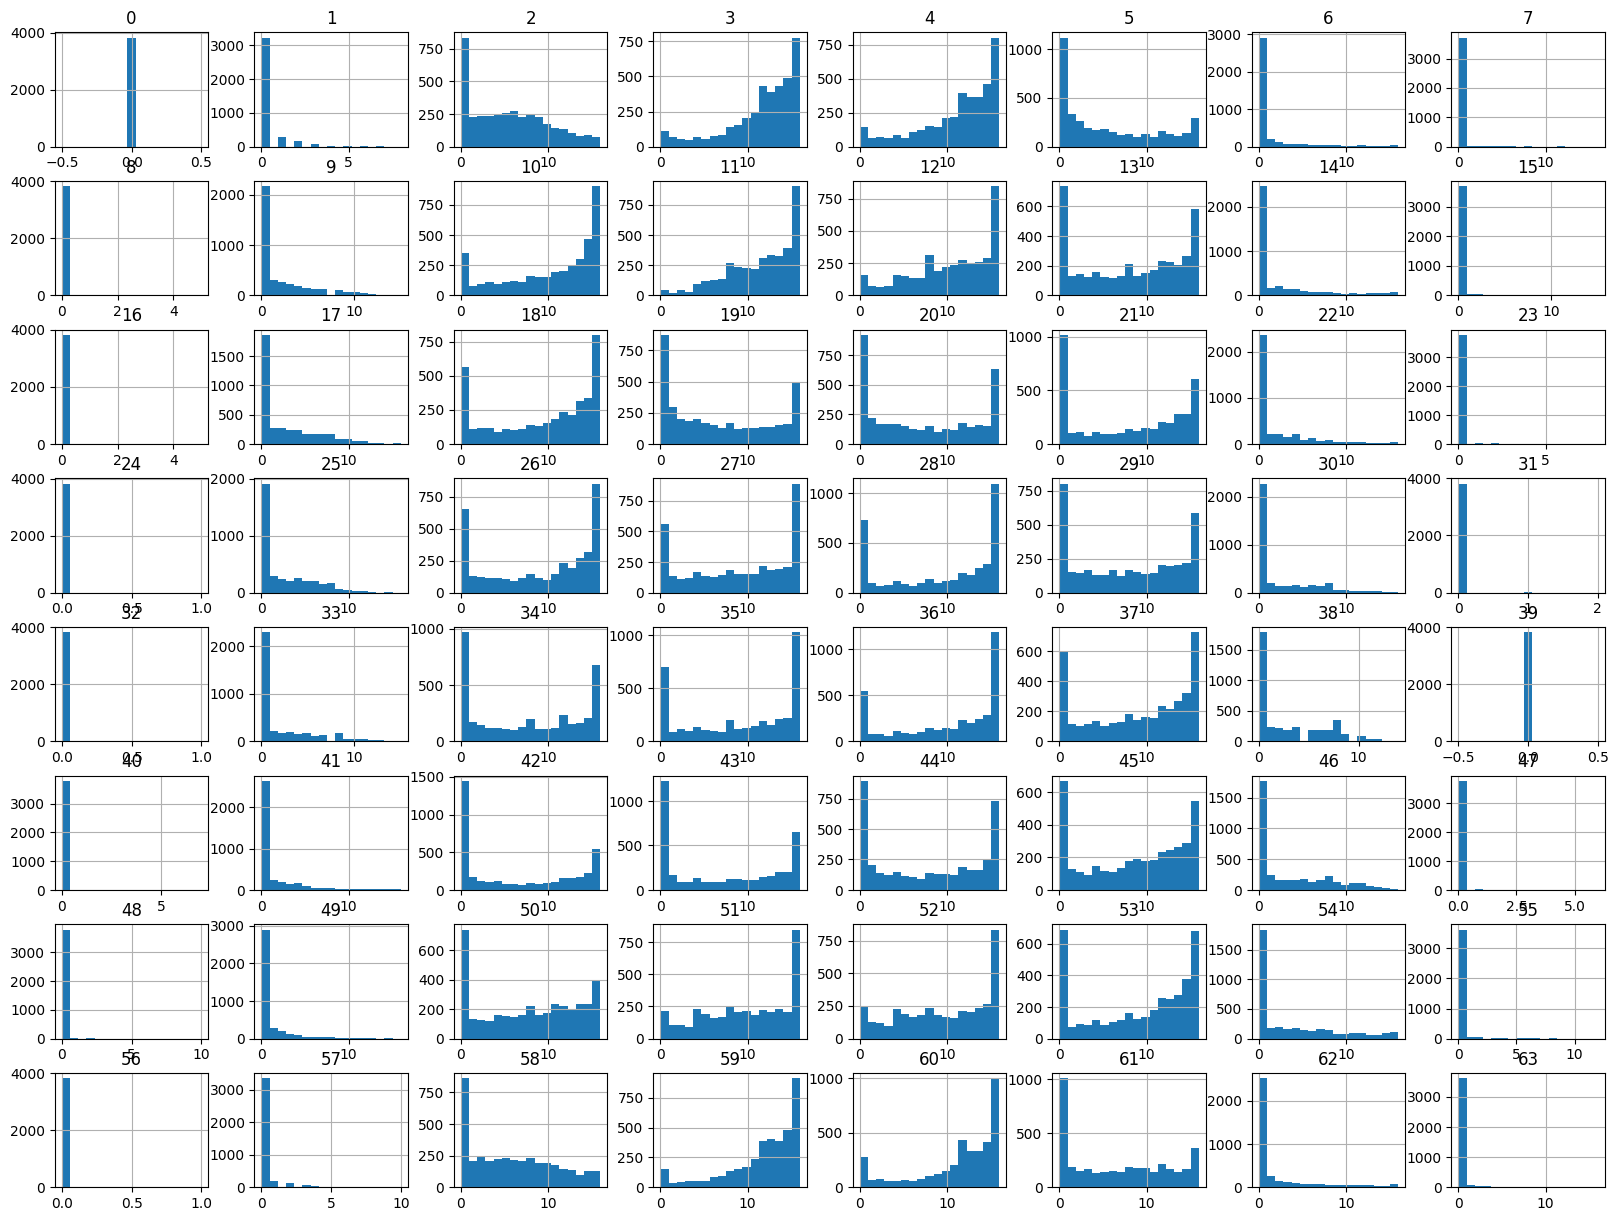

In [ ]:
trainData.hist(bins=17, figsize=(20,15)); # histograma de los 64 atributos, usamos 17 barras pq todos los atributos tienen su dominio en el rango de enteros [0,16]

Comentarios sobre los <b>histogramas</b>:

- Muchas de las características concentran sus valores en 0, como se puede ver en aquellas gráficas con una sola barra muy elevada y el resto nulos o muy bajos.
- El resto de gráficas son más variadas, acumulando valores en uno o ambos extremos casi siempre.
- Todos los atributos toman valores enteros en el rango [0,16], luego están escalados.

A continuación, buscamos <b>correlaciones entre las características</b>. En primer lugar, representamos dos atributos con una aparente distribución normal (exceptuando la acumulación en 0), según hemos visto en los histogramas. Parece que tienen una correlación lineal.

<Axes: xlabel='2', ylabel='58'>

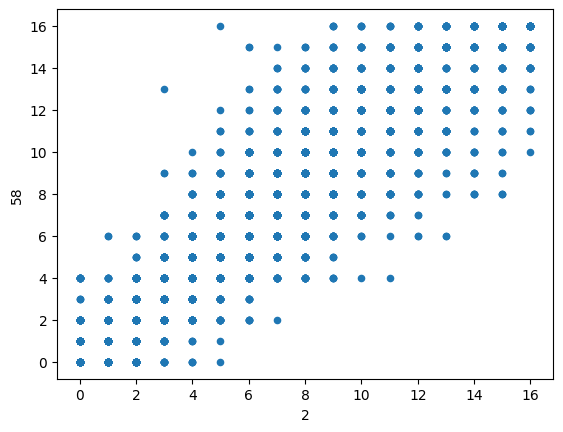

In [ ]:
trainData.plot(kind="scatter", x=2, y=58)

Usando los <b>mapas de calor</b>, vemos que la relación que hemos deducido anteriormente entre las características 2 y 58 se representa con color rojo en el diagrama. Además, obtenemos dos líneas diagonales que nos muestran las correlaciones entre los atributos que tienen los valores concentrados en 0.

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


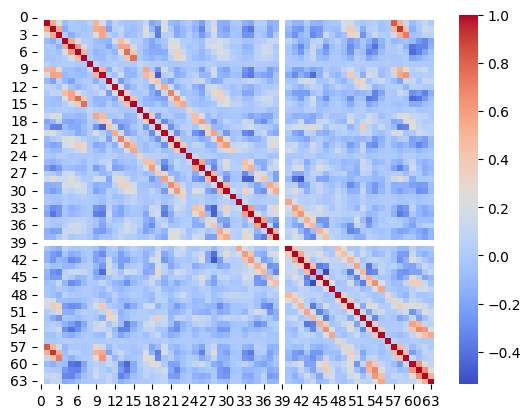

In [ ]:
corr = np.corrcoef(trainData.T)
sns.heatmap(corr, cmap='coolwarm')
plt.show();

Otra correlación que sacamos del mapa de calor de las que concentran sus valores en 0:

<Axes: xlabel='7', ylabel='15'>

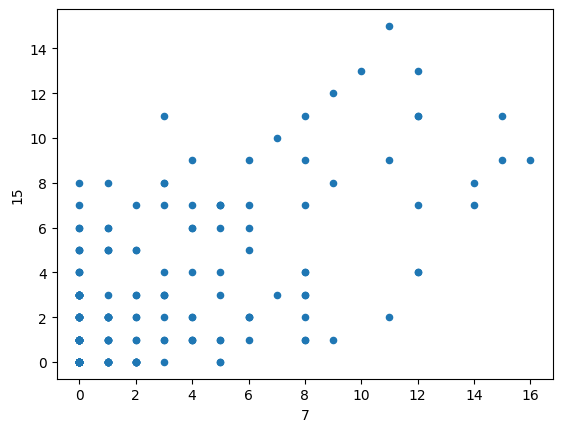

In [ ]:
trainData.plot(kind="scatter", x=7, y=15)

### 2. Preprocesamiento de datos

En primer lugar, destacamos que <b>no hay valores perdidos</b> según se indica en la página web del conjunto de datos (https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits). Además, como mencionamos en los histogramas, todos los valores son numéricos y enteros entre [0,16] por lo que <b>no hace falta que hagamos escalado</b> de ningún tipo. Se han hecho algunas pruebas añadiendo características polinomiales a los datos de entrenamiento pero no han mejorado los resultados significativamente, por lo que se van a entrenar los modelos con el conjunto de datos trainData <b>sin preprocesar</b>.

**Corrección**: sí hace falta escalar los datos, sobre todo para SVM, el resto de clasificadores no lo necesitan. Es el único preprocesamiento necesario. Hacer stratified KFold para el cross-validate, puede haber sesgo de clases en la creación de particiones.

### 3. Protocolo de validación experimental

El protocolo a seguir es el siguiente:
- <b>Entrenamos</b> los modelos con el conjunto de datos trainData y sus respectivas etiquetas esperadas y_train.
- <b>Validamos</b> los 2 primeros modelos (Naïve-Bayes y SVM lineal) usando cross-validation, obteniendo el train accuracy y el test accuracy. Para el tercero (Random Forest Classifier), empleamos el out-of-bag error, el cual es menos costoso y está demostrado que es equivalente a la validación cruzada para un número de árboles elevado. Así, la métrica que usamos para comparar los modelos es la precisión o accuracy en la clasificación.
- En el apartado 5 estimamos los mejores <b>hiperparámetros</b> y volvemos a entrenar y validar los modelos con las mismas métricas.
- Posteriormente <b>testeamos</b> los clasificadores haciendo predicciones sobre el conjunto testData y mostramos una matriz de confusión para observar mejor el comportamiento de los mismos frente a nuevos datos.

### 4. Modelos de Apredizaje Automático

#### 4.1 Naïve-Bayes

En primer lugar, usamos el algoritmo de <b>Naïve-Bayes</b> apropiado para datos discretos (<b>MultinomialNB</b>), pues tenemos valores enteros como dominios de nuestros atributos. Este algoritmo es el más sencillo, supone la independencia de todos los atributos frente a la variable de la clase y usa el teorema de Bayes sobre la probabilidad condicionada. A pesar de esta suposición poco realista, se considera un estándar y sus resultados son competitivos con la mayoría de los clasificadores, aunque no llega a superar a los siguientes clasificadores.

In [ ]:
# selección del modelo y entrenamiento con los trainData
naiveModel = MultinomialNB()
naiveModel.fit(trainData, y_train)

# validación empleando cross-validation con 5 capas, se obtiene la precisión media en test y training
nb_metrics = cross_validate(naiveModel, trainData, y_train, return_train_score=True, cv=5)
nb_test_acc  = np.mean(nb_metrics.get('test_score'))
nb_train_acc = np.mean(nb_metrics.get('train_score'))
print("Train accuracy = ", nb_train_acc)
print("Test accuracy  = ", nb_test_acc)

Train accuracy =  0.9182578463960681
Test accuracy  =  0.9144646340211476


Obtenemos un <b>91% de precisión</b> al clasificar con el modelo de Naïve-Bayes. Viendo la <b>matriz de confusión</b> que aparece más abajo en el testeo, el modelo se equivoca 21 veces al decir que un '8' es un '1', o clasificar un '1' como un '2' en 19 ocasiones, entre otras pequeñas confusiones. No obstante, la diagonal está llena de tonos amarillos indicando el buen criterio general del modelo. Tampoco se observa ningún signo de overfitting según la diferencia entre <i>train accuracy</i> y <i>test accuracy</i>.

#### 4.2 SVM para clasificación

En segundo lugar, aplicamos el clasificador <b>SVM lineal</b> con un hiperparámetro de regularización C=100. Más tarde se estimarán los mejores hiperparámetros usando GridSearchCV.

In [ ]:
# selección del modelo y entrenamiento con los trainData
svcModel = SVC(kernel="linear", C=100, random_state=42) # hiperparámetro de regularización C
svcModel.fit(trainData, y_train)

# validación empleando cross-validation con 5 capas, se obtiene la precisión media en test y training
svc_metrics = cross_validate(svcModel, trainData, y_train, return_train_score=True, cv=5)
svc_test_acc  = np.mean(svc_metrics.get('test_score'))
svc_train_acc = np.mean(svc_metrics.get('train_score'))
print("Train accuracy = ", svc_train_acc)
print("Test accuracy  = ", svc_test_acc)

Train accuracy =  1.0
Test accuracy  =  0.9780292919960305


Usando un SVM lineal obtenemos una precisión del <b>97,8%</b> bastante buena. Como curiosidad, he probado este modelo añadiéndole <b>características polinómicas</b> de grado 2 al conjunto de entrenamiento como preprocesamiento previo y sólo llega a mejorar una centésima sobre 1 en el test accuracy. He considerado que no compensa complicar más el modelo por esa mínima mejora.

**Corrección**: Si vas a usar un SVM lineal, yo no usaría SVC que es más lento. El tipo de kernel se podría haber incluido en el GridSearch.

#### 4.3 Random Forest

En tercer lugar, seleccionamos como clasificador el <b>RandomForestClassifier</b>. Le añadimos el parámetro <b><i>oob_score</i></b> en su llamada para que devuelva el out-of-bag error del modelo automáticamente como métrica de validación. Esto es una ventaja de los <b>métodos ensemble de tipo bagging</b>, no necesitan recurrir a la validación cruzada (más costosa) para obtener una estimación del error de test. De hecho, si el número de árboles es suficientemente alto, el OOB-error es prácticamente equivalente al leave-one-out cross-validation error.

También le pasamos el parámetro <b><i>n_jobs=-1</i></b>, con el cual le estamos diciendo que use todos los núcleos de nuestro ordenador para trabajar de forma paralela, haciendo la ejecución más rápida.


In [ ]:
# selección del modelo y entrenamiento con los trainData
rfModel = RandomForestClassifier( oob_score=True, n_jobs=-1 )
rfModel.fit(trainData, y_train)

# validación empleando out-of-bag error, se obtiene la precisión media en test
rf_test_acc = rfModel.oob_score_
print("OOB-error = ", rf_test_acc)

OOB-error =  0.9769814281977505


Con el RandomForestClassifier obtenemos una <b>precisión muy similar a la del SVM lineal</b>. Quizás este algoritmo mejore con la optimización de hiperparámetros que se hará en el siguiente apartado, porque hoy en día es un clasificador muy prometedor.

In [ ]:
clasificadores = np.array(["Naïve-Bayes", "SVM lineal", "Random Forest"])
precision = np.array([nb_test_acc, svc_test_acc, rf_test_acc])

table = [["Clasificador", clasificadores[0], clasificadores[1], clasificadores[2]],
         ["Precisión", precision[0], precision[1], precision[2]]]
print(tabulate(table))

------------  ------------------  ------------------  ------------------
Clasificador  Naïve-Bayes         SVM lineal          Random Forest
Precisión     0.9144646340211476  0.9780292919960305  0.9769814281977505
------------  ------------------  ------------------  ------------------


### 5. Selección y estimación de hiperparámetros

Vamos a utilizar <b>GridSearch</b> para analizar varias combinaciones de hiperparámetros y mejorar los modelos expuestos anteriormente. En concreto, vamos a mejorar <b>RandomForest</b> analizando los hiperparámetros n_estimators, max_features, max_depth y criterion; y <b>SVM lineal</b> probando con C y gamma.

In [ ]:
# GridSearch basado en validación cruzada aplicado a SVM lineal
svm_params = [{'C'     : [1, 10, 100, 1000],
               'gamma' : [0.015625, 0.05, 0.1]}]

svm_grid = GridSearchCV( estimator = SVC(kernel="linear"),
                     param_grid = svm_params,
                     scoring = 'accuracy',
                     cv = RepeatedKFold(n_splits = 5) )

svm_grid.fit(trainData, y_train) # entrenamos cada modelo

cvres = svm_grid.cv_results_
for mean_test_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    # imprimimos la precisión media junto a los params por cada iteración
    print(np.mean(mean_test_score), params)

# imprimimos el mejor resultado con sus hiperparámetros asociados
print("\nMejor resultado:")
print(svm_grid.best_params_)
print(svm_grid.best_score_)

0.9798325976114703 {'C': 1, 'gamma': 0.015625}
0.9798325976114703 {'C': 1, 'gamma': 0.05}
0.9798325976114703 {'C': 1, 'gamma': 0.1}
0.9798325976114703 {'C': 10, 'gamma': 0.015625}
0.9798325976114703 {'C': 10, 'gamma': 0.05}
0.9798325976114703 {'C': 10, 'gamma': 0.1}
0.9798325976114703 {'C': 100, 'gamma': 0.015625}
0.9798325976114703 {'C': 100, 'gamma': 0.05}
0.9798325976114703 {'C': 100, 'gamma': 0.1}
0.9798325976114703 {'C': 1000, 'gamma': 0.015625}
0.9798325976114703 {'C': 1000, 'gamma': 0.05}
0.9798325976114703 {'C': 1000, 'gamma': 0.1}

Mejor resultado:
{'C': 1, 'gamma': 0.015625}
0.9798325976114703


Al aplicar GridSearch al SVM lineal nos damos cuenta de que obtiene mejores resultados con más regularización, es decir, con un valor de <b>C</b> bajo (C=1). Mientras que el <b>gamma</b> se mantiene en su valor por defecto: gamma = 1/num_features. No obstante esta mejora es sólo de una décima, llegando a una precisión del <b>97,9%</b>. Probando otras combinaciones de los hiperparámetros no llego a obtener mejores resultados. Con esto podemos concluir que la regularización no influye prácticamente en la precisión en este problema.

In [ ]:
# GridSearch basado en out-of-bag score aplicado a Random Forest
params = ParameterGrid({'n_estimators': [200],
                        'max_features': [10, 20, 30],
                        'max_depth'   : [3, 10, 20],
                        'criterion'   : ['gini', 'entropy']})

rf_results = {'params': [], 'oob_accuracy': []}

# ajustamos y validamos el modelo para cada secuencia de hiperparámetros
for p in params:
    rf = RandomForestClassifier( oob_score=True, n_jobs =-1, **p )
    rf.fit(trainData, y_train)

    rf_results['params'].append(p)
    rf_results['oob_accuracy'].append(rf.oob_score_)
    print(f"Modelo: {p} \u2713") # mostramos cada calculado paso por pantalla

# guardamos los resultados y los ordenamos en orden descendiente de oob accuracy
rf_results = pd.DataFrame(rf_results)
rf_results = pd.concat([rf_results, rf_results['params'].apply(pd.Series)], axis=1)
rf_results = rf_results.sort_values('oob_accuracy', ascending=False)
rf_results = rf_results.drop(columns='params')
rf_results.head(4)

# mostramos la mejor combinación de hiperparámetros obtenida junto a su valor de oob-accuracy
print(rf_results.iloc[0,0:])
best_rf_accuracy = (rf_results.iloc[0,0:]).get('oob_accuracy')
print(best_rf_accuracy)

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 10, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 20, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 30, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 20, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 30, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 10, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 20, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 30, 'n_estimators': 200} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 10, 'n_estimators': 200} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 20, 'n_estimators': 200} ✓
Modelo: {

Al estimar varios hiperparámetros conseguimos mejorar la precisión del Random Forest hasta el <b>98.2%</b>. El criterio de clasificación que ha dado mejores resultados ha sido el de 'Entropy' y vemos cómo se ha preferido escoger el mínimo número de características dadas (10) frente al máximo de las profundidades especificadas (20) para cada subárbol.

In [ ]:
# tabla comparando valores de precisión obtenidos
clasificadores = np.array(["Naïve-Bayes", "SVM lineal", "Random Forest", "SVM lineal con est. hiper.", "Random Forest con est. de hiper."])
precision = np.array([nb_test_acc, svc_test_acc, rf_test_acc, svm_grid.best_score_, best_rf_accuracy])

table = [["Clasificador", clasificadores[0], clasificadores[1], clasificadores[2], clasificadores[3], clasificadores[4]],
         ["Precisión", precision[0], precision[1], precision[2], precision[3], precision[4]]]
print(tabulate(table))

------------  ------------------  ------------------  ------------------  --------------------------  --------------------------------
Clasificador  Naïve-Bayes         SVM lineal          Random Forest       SVM lineal con est. hiper.  Random Forest con est. de hiper.
Precisión     0.9144646340211476  0.9780292919960305  0.9769814281977505  0.9798325976114703          0.9827360711483129
------------  ------------------  ------------------  ------------------  --------------------------  --------------------------------


Observamos que los mejores hiperparámetros estimados encontrados han mejorado muy poco la precisión de los modelos. Por ello, la <b>estimación del error fuera de la muestra</b> que hacemos a continuación usando el conjunto de datos de test (<i>testData</i>), la vamos a realizar sobre los primeros modelos entrenamos en el apartado 4.

### 6. Entrenamiento y estimación del error fuera de la muestra

Modelo Naïve-Bayes
  Out accuracy: 0.87
Train accuracy: 0.91


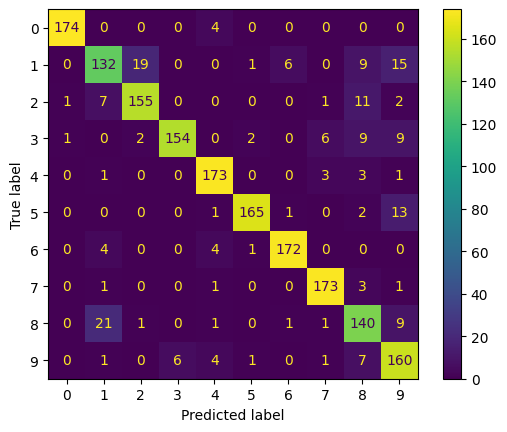

Modelo SVM lineal
  Out accuracy: 0.95
Train accuracy: 0.98


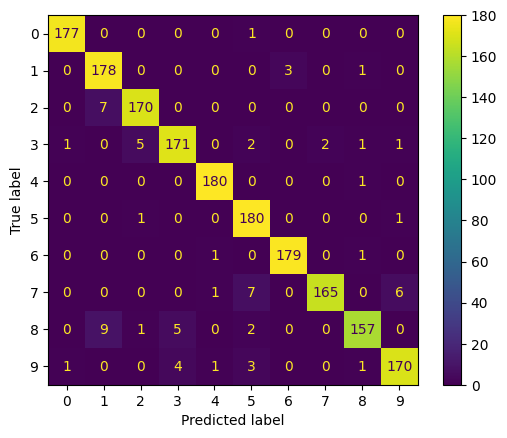

Modelo Random Forest
  Out accuracy: 0.94
Train accuracy: 0.98


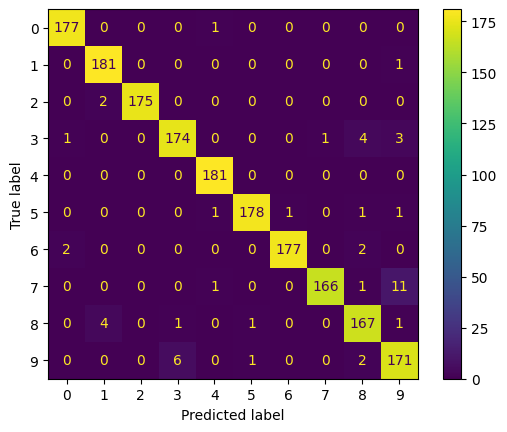

In [ ]:
# recuperamos los modelos del apartado 4
modelos = [naiveModel, svcModel, rfModel]
names = ["Naïve-Bayes", "SVM lineal", "Random Forest"]

# hacemos predicción de los testData para cada modelo e imprimimos las métricas obtenidas
# métricas: accuracy y confusion matrix
m = 0
for model in modelos:
    m += 1

    # predicción de los datos del conjunto de testeo usando el modelo entrenado
    y_pred = []
    for i in range(nexamplesTest):
        y_pred.append( model.predict( testData.iloc[i].to_numpy().reshape(1,-1) ) )

    # métrica: accuracy (f1 sólo vale para clasificadores binarios)
    metrics = cross_validate(model, testData, y_test, cv=5)
    print( "Modelo {}".format(names[m-1]))
    print( "  Out accuracy: {:3.2f}".format(np.mean(metrics.get('test_score'))) )
    print( "Train accuracy: {:3.2f}".format(precision[m-1]))

    # matriz de confusión con los resultados obtenidos de la predicción
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm_display.plot()
    plt.show()

<b>Conclusiones</b>: Al testear los modelos en un conjunto de datos diferente al de entrenamiento, el SVM lineal y el Random Forest obtienen una precisión muy parecida, quedándose el Naïve-Bayes un poco por detrás. Además, el Random Forest tarda bastante más en comparación a los otros, luego a la hora de decantarme por uno de los tres, <b>elijo el SVM como mejor clasificador para este problema</b>. Cabe destacar que en los tres modelos se obtienen resultados ligeramente peores respecto a los datos de entrenamiento, empeorando unas 3 o 4 décimas.

**Corrección**: Solo usas accuracy, ampliar a otras métricas como F1-score podría ser útil. Falta curvas de aprendizaje.



---

## <font color='blue'> Ejercicio 3: PROBLEMA DE REGRESIÓN (4 puntos).

<font color='blue'> En este ejercicio los alumnos se enfrentarán a un problema de regresión, que tendrán que abordar de comienzo a fin (desde el análisis exploratorio hasta el entrenamiento y validación de los modelos de aprendizaje automático seleccionados). Más concretamente, se enfrentarán al problema $\textit{YearPredictionMSD}$ (https://archive.ics.uci.edu/dataset/203/yearpredictionmsd). Este conjunto de datos contiene información (características sonoras) de distintas canciones, y el objetivo es predecir el año de publicación de la canción (hay 89 posibles años a predecir). Cada fila/ejemplo contiene 90 valores reales y un valor entero, correspondiente con el año de la canción, en el rango $[1922, 2011]$). En total hay 515345 ejemplos/instancias. El alumnado debe realizar, al menos, las siguientes tareas (que deben ser descritas y abordadas, explícitamente, en la documentación entregada; de hecho, se debe incluir un subapartado en el Notebook para cada una de ellas):
1. <font color='blue'> Análisis descriptivo del problema y análisis exploratorio de los datos a nuestra disposición.
2. Preprocesado de datos (selección/extracción de características, reducción de dimensionalidad, procesado de datos extremos/atípicos, imputación de datos faltantes, escalado de variables, codificación/transformación de datos, desbalanceo de datos).
3. Definición del protocolo de validación experimental (entrenamiento, validación y test), junto con las métricas de evaluación del rendimiento que corresponda.
4. Selección de, al menos, 3 modelos de aprendizaje automático a emplear en la resolución del problema, de los cuales 1 por lo menos debe ser un $ensemble$.
5. Selección y estimación de valores para hiperparámetros (incluyendo el tipo de regularización a usar).
6. Entrenamiento y estimación del error fuera de la muestra. Discusión de resultados y extracción de conclusiones.


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import numpy as np
datos = np.loadtxt("drive/MyDrive/Colab Notebooks/regresion/YearPredictionMSD.txt",delimiter=",")
datos.shape

(515345, 91)

### 1. Análisis descriptivo del problema

Igual que antes, usamos el paquete <b>Pandas</b> para poder trabajar con los datos en forma de DataFrames. En primer lugar, convertimos los datos numpy.ndarray que obtenemos del drive a DataFrames y separamos los datos de las etiquetas.

In [ ]:
datos = pd.DataFrame(datos) # transformamos el objeto np.ndarray a pandas DataFrame
y_datos = datos.loc[:, 0]   # la primera columna de los datos son las etiquetas, como se indica en su página web
del datos [0]               # una vez recogidas, eliminamos las etiquetas de los datos

# mostramos las 89 clases que tenemos
nClases = y_datos.unique()
print(np.sort(nClases))

print(y_datos.value_counts())  # ejemplos de cada clase

datos.describe()  # resumen de los atributos numéricos

[1922. 1924. 1925. 1926. 1927. 1928. 1929. 1930. 1931. 1932. 1933. 1934.
 1935. 1936. 1937. 1938. 1939. 1940. 1941. 1942. 1943. 1944. 1945. 1946.
 1947. 1948. 1949. 1950. 1951. 1952. 1953. 1954. 1955. 1956. 1957. 1958.
 1959. 1960. 1961. 1962. 1963. 1964. 1965. 1966. 1967. 1968. 1969. 1970.
 1971. 1972. 1973. 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982.
 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994.
 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006.
 2007. 2008. 2009. 2010. 2011.]
0
2007.0    39404
2006.0    37534
2005.0    34952
2008.0    34760
2009.0    31038
          ...  
1925.0        7
1922.0        6
1933.0        6
1924.0        5
2011.0        1
Name: count, Length: 89, dtype: int64


,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,-2.444850,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,1.783520,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,6.147220,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,60.345350,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


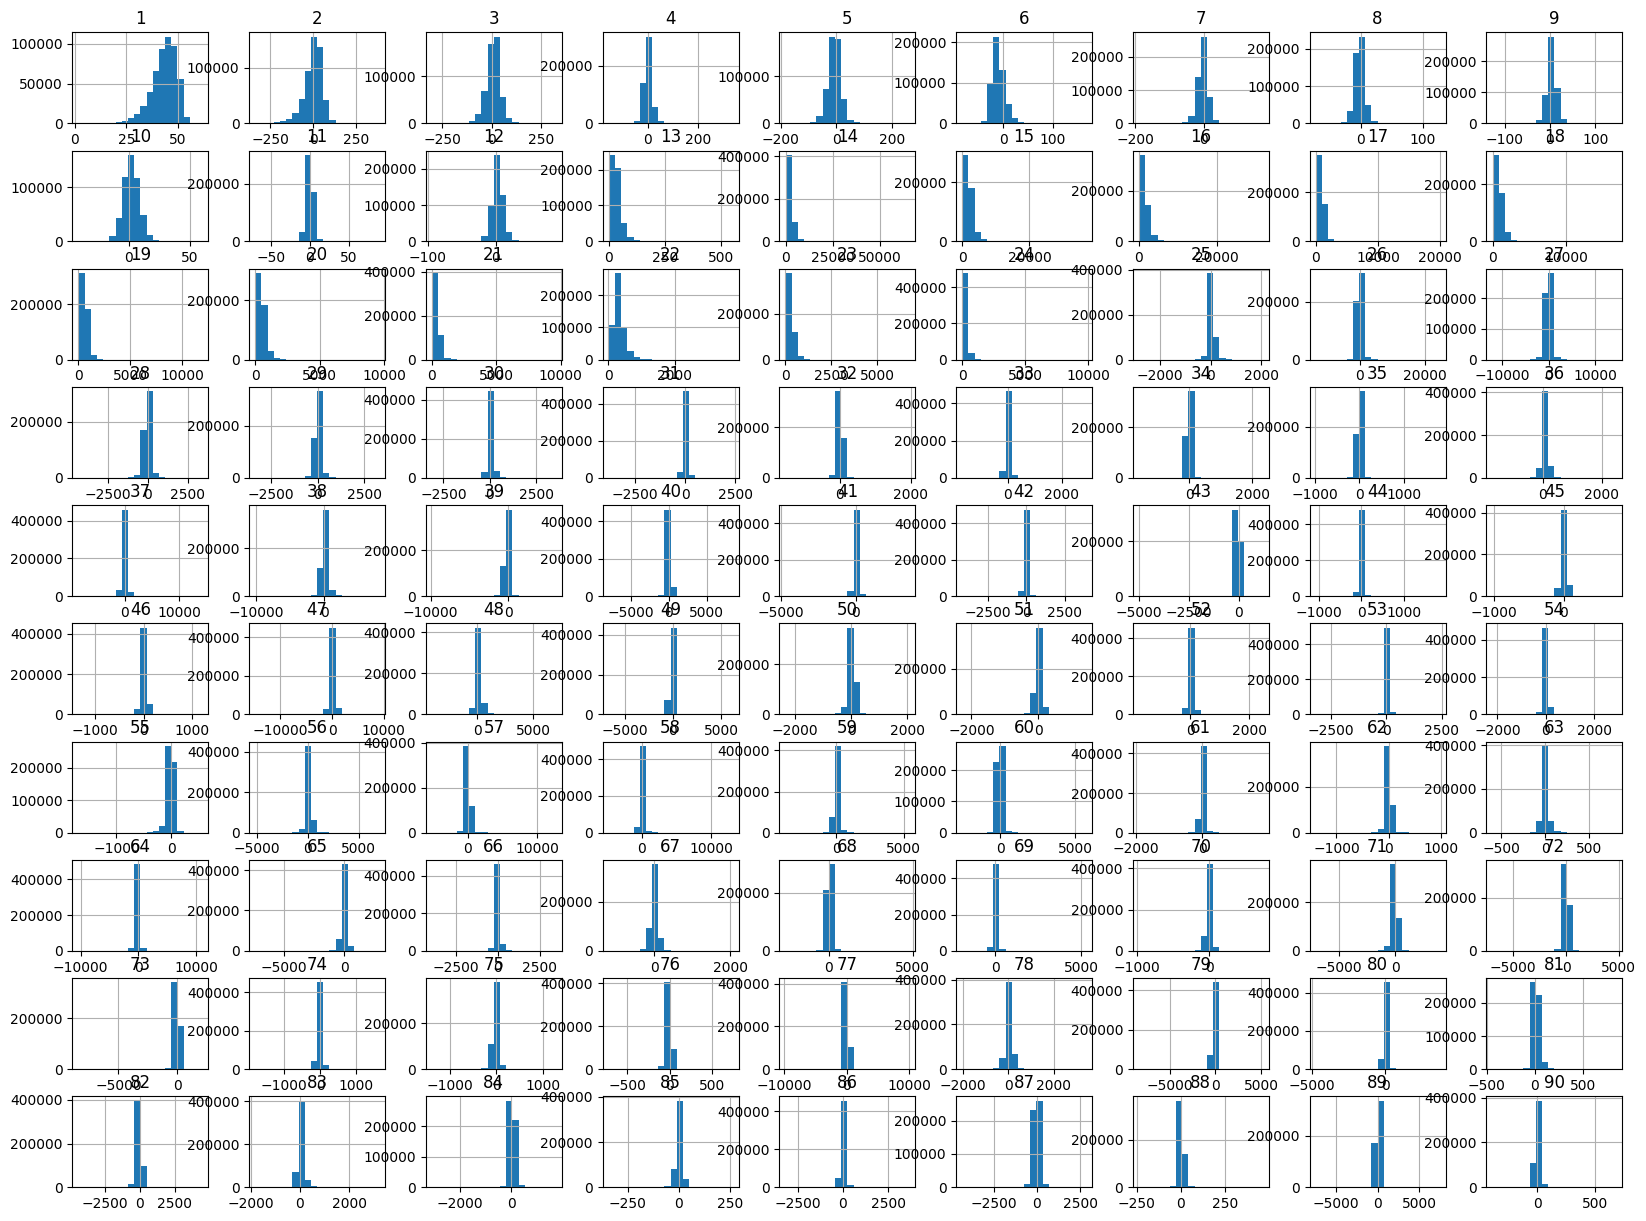

In [ ]:
datos.hist(bins=20, figsize=(20,15));

Observamos cómo la mayoría de los <b>histogramas</b> representan distribuciones normales de media 0 y con varianza muy pequeña (la campana de Gauss es muy estrecha) y en otras se ve una asimetría hacia la izquierda, como en la 1, la 2 o la 6. Además, vemos que <b>no están escalados los datos</b>, usaremos un StandardScaler para escalarlos posteriormente.



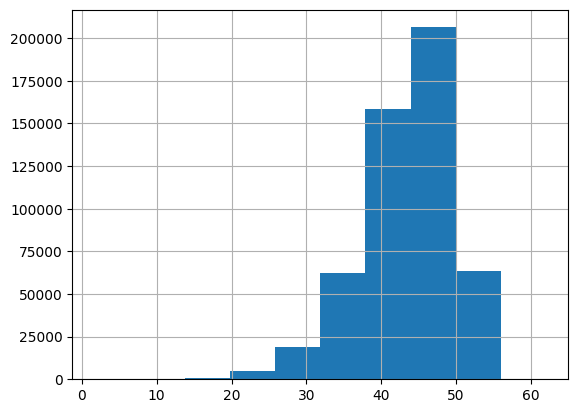

In [ ]:
# el atributo primero es el único que no está centrado en 0, lo tratamos de centrar con las siguientes celdas de código
# esto nos vendrá bien para luego aplicar el PCA sobre datos centrados

datos[1].hist(bins=10);

In [ ]:
datos[1] = pd.cut(datos[1], bins=[0., 35.0, 45.0, 50.0, np.inf], labels=[1, 2, 3, 4]) # sustituimos una columna del dataset
datos[1].value_counts()

1
2    236073
3    169117
4     61871
1     48284
Name: count, dtype: int64

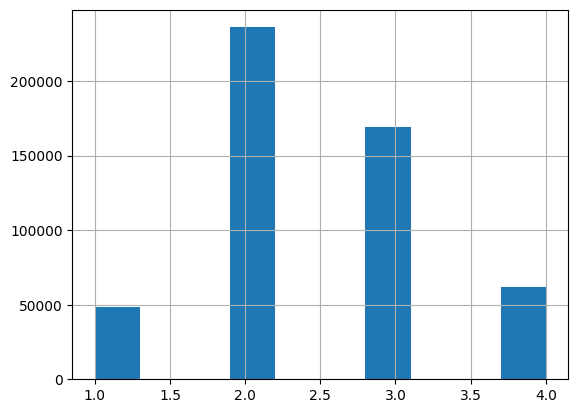

In [ ]:
datos[1].hist(bins=10);

Estudiamos ahora posibles <b>correlaciones</b> entre los atributos mediante los mapas de calor y la matriz de correlación. Mostramos 3 gráficas de pares de atributos que hemos observado que están correlacionados.

In [ ]:
corr = np.corrcoef(datos.T)
sns.heatmap(corr, cmap='coolwarm')
plt.show();

NameError: name 'np' is not defined

In [ ]:
datos.corr()

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
1,1.000000,0.507497,0.241324,-0.036508,-0.260289,-0.315762,0.149643,0.007151,0.170339,0.132828,...,-0.320324,0.187996,-0.115972,0.015224,0.099975,-0.047381,0.041642,-0.136153,-0.100372,-0.150955
2,0.507497,1.000000,0.018479,0.126845,-0.184864,-0.112388,0.115468,0.108088,0.126086,0.371357,...,-0.289733,0.053480,-0.151313,0.022337,0.150309,0.048165,-0.004499,-0.015567,-0.121116,-0.159893
3,0.241324,0.018479,1.000000,0.152488,-0.131741,0.040808,-0.057642,0.080881,0.043885,-0.089869,...,0.070644,0.172473,0.109202,-0.007989,-0.033774,-0.093817,0.078392,-0.060559,-0.099712,0.094694
4,-0.036508,0.126845,0.152488,1.000000,0.034988,0.321159,0.282162,0.031649,-0.037905,0.165343,...,-0.018894,-0.090732,0.043403,0.058974,-0.067529,0.041973,0.031072,0.248128,0.034055,0.011724
5,-0.260289,-0.184864,-0.131741,0.034988,1.000000,0.015561,-0.103110,-0.013265,-0.217551,-0.104766,...,0.038511,-0.088296,0.034104,-0.010014,0.007378,0.004524,-0.006359,-0.016779,0.006124,0.031739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,-0.047381,0.048165,-0.093817,0.041973,0.004524,0.211509,-0.017750,-0.028124,0.012582,0.033973,...,-0.023269,-0.139944,0.081741,0.088437,0.055266,1.000000,0.009603,0.152288,0.152311,-0.010400
87,0.041642,-0.004499,0.078392,0.031072,-0.006359,-0.038859,0.016209,0.013734,0.060279,0.021224,...,0.048025,-0.014376,0.145660,0.329289,0.005876,0.009603,1.000000,0.012255,0.108086,0.249920
88,-0.136153,-0.015567,-0.060559,0.248128,-0.016779,0.146493,0.068457,0.047882,-0.010335,0.040876,...,0.078496,0.027713,0.273890,0.005454,-0.215873,0.152288,0.012255,1.000000,0.065642,0.224785
89,-0.100372,-0.121116,-0.099712,0.034055,0.006124,-0.018272,0.079342,0.000330,-0.007362,-0.031074,...,0.101536,-0.055384,0.046201,0.061739,-0.035505,0.152311,0.108086,0.065642,1.000000,0.199018


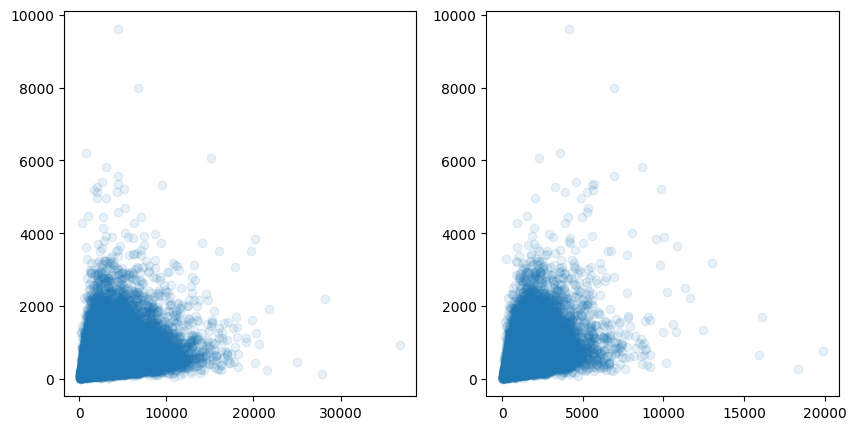

In [ ]:
# sacamos estas correlaciones del cuadrado anaranjado que sale en el mapa de calor:
plt.figure(figsize=(10,5))

ax = plt.subplot(1, 2, 1)
plt.scatter(datos[15], datos[21], alpha=0.1) # comparamos características 15 y 21

ax = plt.subplot(1, 2, 2)
plt.scatter(datos[17], datos[21], alpha=0.1)  # comparamos características 17 y 21

### 2. Preprocesamiento de datos

En primer lugar, destacamos que <b>no hay valores perdidos</b> según se indica en la página web del conjunto de datos. Necesitamos escalar los datos, pero previamente vamos a aplicar <b>PCA</b> para intentar reducir la dimensión de las características.

Establecemos el parámetro <b>'n_components = 0.95'</b> indicando que queremos conservar suficientes atributos como para explicar al menos el 95% de la varianza total de nuestros datos, lo cual está muy bien. Con ello, scikit-learn selecciona automáticamente el número de componentes que logra explicar la cantidad especificada de varianza en los datos y elimina el resto. Nos viene muy bien para tener un conjunto de datos más manejable.

**Corrección**: EDA (Exploratory Data Analysis) completo. Data Snooping porque se aplica PCA y StandardScaler a todos los datos antes de hacer el split train-test. Además, es muy conveniente usar StandardScaler antes de PCA, a pesar de que se haya estudiado las medidas de los 90 atributos por correlaciones, est no implica que la varianza sea 1. PCA funciona óptimamente con un standardscaler previo. PCA está configurado con 0.95 de preservación de varianza sin hacer un estudio previo. Se particiona siguiendo las recomendaciones de la web, pero con Data Snooping. Se usa CV para la selección de modelos. Hacer un Polynomial features en este conjunto de datos es muy pesado. Se subestima el tamaño del conjunto de datos. Se opta por Risge regression cuando un lasso podría eliminar características y reducir cómputo, que es lo que importa en este conjunto de datos. Echo en falta un estudio por intervalos anuales, puesto que el problema es desbalanceado y el error es diferente según qué años estamos prediciendo. No se analiza importancia de variables. El grid search también es muy pesado computacionalmente, hacer un cross_validate o probar parámetros por defecto también es válido. Yo no he tenido tiempo de ejecutarlo y comprobar resultados.

In [ ]:
datosRed = PCA(n_components=0.95).fit_transform(datos) # devuelve un ndarray of shape (n_samples, n_components)

In [ ]:
datosRed.shape # observamos cómo el n_samples se mantiene, mientras que pasamos de tener 90 atributos a sólo 23, manteniendo el 95% de explicabilidad!

(515345, 23)

In [ ]:
datosRed = pd.DataFrame(datosRed)
datosRed.describe()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
count,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,...,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05
mean,4.470518e-13,5.727922e-13,-3.255188e-13,2.476405e-14,-9.487709e-15,7.929014e-14,1.492055e-13,9.883030e-15,5.511907e-14,1.144173e-13,...,-4.952810e-14,-3.933446e-14,1.653431e-13,6.620219e-14,-2.908435e-15,-1.173469e-13,8.219858e-14,2.528644e-14,-1.068497e-13,-6.653397e-14
std,2.114522e+03,1.173353e+03,9.343963e+02,6.862873e+02,5.432658e+02,4.650938e+02,4.124710e+02,3.941005e+02,3.843526e+02,3.473188e+02,...,2.619851e+02,2.597737e+02,2.504911e+02,2.337857e+02,2.289329e+02,2.221274e+02,1.956700e+02,1.931384e+02,1.902761e+02,1.861881e+02
min,-3.673723e+03,-2.487952e+04,-1.670180e+04,-1.784888e+04,-8.429345e+03,-8.251562e+03,-8.705093e+03,-8.867777e+03,-6.756407e+03,-5.801661e+03,...,-4.226844e+03,-7.953603e+03,-5.665718e+03,-3.632416e+03,-4.530424e+03,-5.247714e+03,-4.167476e+03,-3.949917e+03,-5.336979e+03,-3.347172e+03
25%,-1.446667e+03,-5.188910e+02,-4.104405e+02,-2.788228e+02,-2.386724e+02,-2.146867e+02,-1.851807e+02,-1.597547e+02,-2.026814e+02,-1.438608e+02,...,-1.292786e+02,-1.025294e+02,-1.175632e+02,-1.031164e+02,-1.069810e+02,-1.015344e+02,-9.083664e+01,-9.103815e+01,-9.207396e+01,-8.634453e+01
50%,-4.239127e+02,5.476737e+01,-5.897085e+01,4.715232e+01,-2.214427e+00,-8.330990e+00,-2.644548e+00,-1.277754e+01,-2.467554e+01,1.825749e+00,...,6.165235e-02,3.527798e+00,-8.833409e+00,-1.203600e+00,-6.077012e+00,8.275797e+00,-7.379904e-01,-4.195805e+00,1.836719e-01,-2.212534e-01
75%,9.322083e+02,5.061774e+02,3.437162e+02,3.091325e+02,2.150023e+02,2.043057e+02,1.893175e+02,1.376452e+02,1.807613e+02,1.551037e+02,...,1.180017e+02,1.130653e+02,1.145920e+02,1.089359e+02,1.019094e+02,1.079987e+02,8.820047e+01,8.732896e+01,9.485640e+01,8.499114e+01
max,5.956909e+04,2.825530e+04,3.075728e+04,1.874057e+04,1.381471e+04,1.015625e+04,1.258336e+04,1.245762e+04,1.035657e+04,1.462164e+04,...,8.547456e+03,1.183251e+04,8.845671e+03,6.136086e+03,4.592819e+03,5.298740e+03,5.592807e+03,4.282405e+03,6.080403e+03,3.365197e+03


A continuación escalamos los datos usando <b>StandardScaler</b>:

In [ ]:
scaler = StandardScaler()
scaler.fit(datosRed)
datosRedSca = scaler.transform(datosRed)

### 3. Protocolo de validación experimental

En primer lugar, separamos los datos en test y training según la recomendación de su página web para asegurarnos estratificación. Aplicamos train_test_split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datosRedSca, y_datos, train_size=463715, test_size=51630)

print(y_train.value_counts())  # ejemplos de cada clase que tenemos en X_train y X_test
print(y_test.value_counts())

0
2007.0    35342
2006.0    33874
2005.0    31374
2008.0    31315
2009.0    27980
          ...  
1922.0        6
1925.0        6
1933.0        5
1924.0        5
2011.0        1
Name: count, Length: 89, dtype: int64
0
2007.0    4062
2006.0    3660
2005.0    3578
2008.0    3445
2009.0    3058
          ... 
1938.0       1
1933.0       1
1944.0       1
1925.0       1
1932.0       1
Name: count, Length: 86, dtype: int64


El protocolo a seguir es el siguiente:
- <b>Entrenamos</b> los modelos con el conjunto de datos X_train y sus respectivas etiquetas esperadas y_train.
- <b>Validamos</b> los modelos mediante validación cruzada con 5 capas y extraemos el coeficiente de determinación R² como métrica para comparar.
- En el apartado 5 estimamos los mejores <b>hiperparámetros</b> del tercer modelo (Random Forest Regressor) y lo volvemos a entrenar y validar con los mejores hiperparámetros obtenidos, calculando también el R².
- Posteriormente <b>testeamos</b> los 3 modelos haciendo predicciones sobre el conjunto X_test y comparamos los resultados obtenidos mediante las métricas R² y MSE.

### 4. Modelos de Apredizaje Automático

#### 4.1 Regresión Ridge

En primer lugar, usamos la <b>regresión de Ridge</b>, un modelo lineal regularizado con el que pretendemos evitar el overfitting. No he usado la regresión de Lasso porque, a pesar de que también evita el sobreajuste, otro de sus beneficios es reducir características, pero en nuestro caso ya las hemos tratado de reducir bastante con el PCA previamente. Tampoco usamos Elastic-net porque es una combinación de los dos anteriormente, luego es un modelo más costoso, y sólo nos interesa la parte de Ridge como ya he mencionado.

En concreto, usamos una función de scikit-learn que emplea cross-validation para estimar el mejor valor del <b>hiperparámetro alpha</b>, llamada <b>RidgeCV</b>. El alpha controla el grado de regularización del modelo.

In [ ]:
# selección del modelo y entrenamiento con los trainData
modeloRidge = RidgeCV(alphas=[1, 5, 10, 20], cv=5).fit(X_train, y_train)

# mejor valor de alpha encontrado
print("Mejor valor de alpha encontrado: {}".format(modeloRidge.alpha_))

# validación usando el coeficiente de determinación (R²)
ridge_r2 = modeloRidge.score(X_train, y_train) # métrica para comparar modelos al final
print("R²: {}".format(ridge_r2))

Mejor valor de alpha encontrado: 20
R²: 0.059241563849598


Observamos que la regresión de Ridge va muy mal con este conjunto de datos. El CV siempre elige el alpha mayor que le proponemos, lo que nos hace pensar que nuestros datos no son lineales. Por ello, a continuación tratamos de emplear un modelo de regresión polinómico añadiéndole características de mayor grado.

#### 4.2 Regresión polinómica

En segundo lugar, aplicamos un <b>regresor polinómico</b> porque intuimos que los datos no son lineales. Tenemos cuidado con coger un grado de polinomio adecuado para obtener un buen equilibrio entre sesgo y varianza. Probando diferentes grados, veo que mi espacio de RAM sólo me permite ejecutarlo con grado 2, lo cual tiene sentido: al aumentar los grados del polinomio, aumenta la complejidad del modelo y con ello, el tiempo de ajuste a nuestro conjunto de datos tan grande crece exponencialmente.

Aclarado esto, para grado 2 obtenemos un <b>error MSE muy alto y un R² muy bajo</b>, aunque ligeramente mejor que el regresor lineal anterior. Concluimos que este método no es viable.

In [ ]:
# creamos un pipeline con un regresor lineal al que previamente le hemos añadido características polinómicas de grado 2
poly = PolynomialFeatures(degree=2, include_bias=True)
regressor = LinearRegression()
pipe = Pipeline( [("polynomial_features", poly), ("linear_regression", regressor)] )
pipe.fit(X_train, y_train)

# evaluamos el modelo con cross-validation sobre los datos de entrenamiento, obtenemos el mse y R²
scores = cross_validate( pipe, X_train, y_train, scoring=["neg_mean_squared_error","r2"], return_train_score=True, cv=5)
mse_train = abs(np.mean(scores.get('train_neg_mean_squared_error')))
mse_test = abs(np.mean(scores.get('test_neg_mean_squared_error' )))
r2_train = np.mean(scores.get('train_r2' ))
r2_test = np.mean(scores.get('test_r2' ))

print("Train mse : {}".format(mse_train))
print("Test mse  : {}".format(mse_test))
print("Train R²  : {}".format(r2_train))
print("Test R²   : {}".format(r2_test))

poli_r2 = r2_test   # métrica para comparar modelos al final
poli_mse = mse_test


Train mse : 109.29098873430067
Test mse  : 109.69979667096939
Train R²  : 0.08498097990188173
Test R²   : 0.08154177262278366


Las métricas de MSE y R² obtenidas en entrenamiento y test nos dicen que no se ha producido ningún tipo de sobreajuste, como cabía esperar al intuir que no se trata de un modelo lineal (ni al parecer cuadrático).

#### 4.3 Random Forest Regressor

Como los métodos anteriores no nos han dado resultado, procedemos a usar un método totalmente diferente, el <b>Random Forest Regressor</b>. Este regresor usa por defecto el criterio del error cuadrático medio (criterion = 'squared_error') para minimizar la función de pérdida correspondiente. De esta manera, empleando unos hiperparámetros escogidos a ojo de primeras obtenemos un coeficiente de regresión <b>R² = ~0.5</b>, lo cual es una muy buena noticia.

In [ ]:
# en primer lugar, inicializamos el modelo con valores de hiperparámetros a ojo
modeloRF = RandomForestRegressor( criterion = 'squared_error',
                                  n_estimators = 10,
                                  max_depth = 20,
                                  max_features = 3,
                                  n_jobs = -1 )
# entrenamiento
modeloRF.fit(X_train, y_train)

# validación: obtenemos el coeficiente de determinación
rf_r2 = modeloRF.score(X_train, y_train)
print("R²: {}".format(rf_r2))

R²: 0.4938120773141227


Mostramos una tabla con los coeficientes de determinación obtenidos por cada modelo:

In [ ]:
regressors = np.array(["Regr. Ridge", "Regr. polinómica (grado=2)", "Random Forest Regressor"])
r2 = np.array([ridge_r2, poli_r2, rf_r2])

table = [["Regresor", regressors[0], regressors[1], regressors[2]],
         ["R²", r2[0], r2[1], r2[2]]]
print(tabulate(table))

--------  -----------------  --------------------------  -----------------------
Regresor  Regr. Ridge        Regr. polinómica (grado=2)  Random Forest Regressor
R²        0.059241563849598  0.08154177262278366         0.49190147408518436
--------  -----------------  --------------------------  -----------------------


### 5. Selección y estimación de hiperparámetros

A continuación, realizamos una <b>optimización de los hiperparámetros del Random Forest Regressor</b> a la cuenta de la vieja, pues emplear un GridSearch es demasiado costoso en cuanto a tiempo y memoria para este problema con tantos ejemplos, como he podido comprobar. Ejemplos de combinaciones de hiperparámetros que he probado, junto a sus comentarios:

Original:
- R² = 0.49 --> n_estimators = 10, max_depth = 20, max_features = 3

Vemos cómo bajando la profundidad disminuye mucho el coeficiente de determinación:
- R² = 0.11 --> n_estimators = 20, max_depth = 10, max_features = 7

Mejores resultados dejando fija la profundidad a 20 y aumentando características y/o número de estimadores:
- R² = 0.58 --> n_estimators = 20, max_depth = 20, max_features = 7
- R² = 0.59 --> n_estimators = 15, max_depth = 20, max_features = 11

In [ ]:
# probamos cambiando los hiperparámetros:
modeloRF_opt = RandomForestRegressor( criterion = 'squared_error',
                                      n_estimators = 15,
                                      max_depth = 20,
                                      max_features = 11,
                                      n_jobs = -1 )
# entrenamiento
modeloRF_opt.fit(X_train, y_train)

# validación: obtenemos el coeficiente de determinación
rf_opt_r2 = modeloRF_opt.score(X_train, y_train)
print("R²: {}".format(rf_opt_r2))

R²: 0.5952205272159098


In [ ]:
'''# definimos los parámetros
params = [{'n_estimators' : [10, 15],
           'max_features' : [5, 7],
           'max_depth'    : [20]}]

grid = GridSearchCV( estimator = RandomForestRegressor( criterion = 'squared_error', n_jobs = -1 ),
                     param_grid = params,
                     scoring = "r2",
                     cv = RepeatedKFold(n_splits = 5) )

# entrenamos cada modelo
grid.fit(X_train, y_train)

# obtenemos los resultados en forma de dictionary
cvres = grid.cv_results_

for test_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    # imprimimos el coef de determinación junto a los params por cada iteración
    print(np.mean(test_score), params)

# imprimimos el mejor resultado con sus hiperparámetros asociados
print("\nMejor resultado:")
print(grid.best_params_)
print(grid.best_score_)

rf_opt_r2 = grid.best_score_'''

'# definimos los parámetros\nparams = [{\'n_estimators\' : [10, 15],\n           \'max_features\' : [5, 7],\n           \'max_depth\'    : [20]}]\n\ngrid = GridSearchCV( estimator = RandomForestRegressor( criterion = \'squared_error\', n_jobs = -1 ),\n                     param_grid = params,\n                     scoring = "r2",\n                     cv = RepeatedKFold(n_splits = 5) )\n\n# entrenamos cada modelo\ngrid.fit(X_train, y_train)\n\n# obtenemos los resultados en forma de dictionary\ncvres = grid.cv_results_\n\nfor test_score, params in zip(cvres["mean_test_score"], cvres["params"]):\n    # imprimimos el coef de determinación junto a los params por cada iteración\n    print(np.mean(test_score), params)\n\n# imprimimos el mejor resultado con sus hiperparámetros asociados\nprint("\nMejor resultado:")\nprint(grid.best_params_)\nprint(grid.best_score_)\n\nrf_opt_r2 = grid.best_score_'

Con dicha combinación de hiperparámetros hemos mejorado el regresor RandomForest en aproximadamente una décima hasta llegar a <b>R² = ~0.6</b>, pero hay que plantearse si merece la pena realizar este estudio tan exhaustivo sobre la optimización de los hiperparámetros conllevando tanto tiempo de ejecución. No obstante, podemos concluir que, tanto sin optimización como con optimización, la <b>técnica de bagging que usa este modelo ha venido muy bien para este conjunto de datos tan extenso y no lineal</b>, en comparación con las otras técnicas mostradas.

### 6. Entrenamiento y estimación del error fuera de la muestra

En este apartado, tomamos los 3 regresores entrenados y validados previamente y con ellos realizamos las <b>predicciones sobre el conjunto de test</b> (X_test). De esta forma, estimamos el error fuera de la muestra con el MSE y comparamos los modelos mediante el R².

In [ ]:
# recuperamos los 3 modelos
modelos = [modeloRidge, pipe, modeloRF_opt]
names = ["Regr. Ridge", "Regr. polinómica (grado=2)", "Random Forest Regressor Opt."]


mse_test = []
r2_test  = []

# hacemos predicción de los X_test para cada modelo e imprimimos las métricas obtenidas
for model in modelos:

    # predicción de los datos del conjunto de testeo usando el modelo entrenado
    y_pred = []
    for i in range(X_test.shape[0]):
        y_pred.append( model.predict( X_test[i].reshape(1, -1) ) )

    # obtenemos las métricas mse y r2
    mse_test.append(mean_squared_error(y_test, y_pred))
    r2_test.append(r2_score(y_test, y_pred ))

# mostramos los resultados de estos 2 modelos en una tabla
table = [["Modelos",    names[0],    names[1],    names[2]],
         ["R² "    ,  r2_test[0],  r2_test[1],  r2_test[2]],
         ["MSE"    , mse_test[0], mse_test[1], mse_test[2]]]

print(tabulate(table))

-------  --------------------  --------------------------  ----------------------------
Modelos  Regr. Ridge           Regr. polinómica (grado=2)  Random Forest Regressor Opt.
R²       0.059989080046971455  0.08421871042831452         0.09290104393012888
MSE      112.70160654225127    109.79662085332039          108.75566173952734
-------  --------------------  --------------------------  ----------------------------


Los resultados de la estimación del error fuera de la muestra son muy malos con cualquiera de los 3 regresores empleados. Ninguno de ellos llega al 0,1 de R². No obstante, llama la atención cómo el Random Forest pasa de tener 0,5 en entrenamiento a ~0,1 en test (<b>sobreentrenamiento</b>). Para comprender mejor que está ocurriendo calculamos la <b>curva de aprendizaje del regresor Random Forest</b>.

Las curvas de aprendizaje evalúan el rendimiento de los modelos a medida que son entrenados, progresivamente, con un mayor número de ejemplos. Aplicándolo al Random Forest Regressor veremos si se trata de un <b>problema complejo</b> o no, en cuyo caso deberíamos considerar muchos más datos de entrenamiento para disminuir el out-example-error y que el modelo generalice mejor.

En concreto, al hacer la llamada <b><i>learning_curve( modeloRF_opt, datosRedSca, y_datos )</i></b> se están contando los tamaños de conjuntos de entrenamiento por defecto, los cuales son: 10%, 32.5%, 55%, 77.5% y 100%.

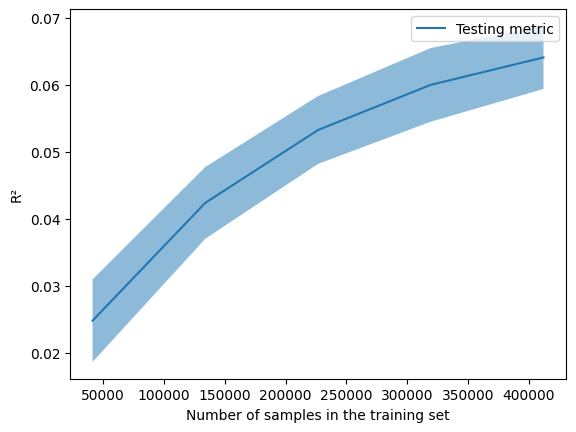

In [ ]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve

train_sizes, train_scores, test_scores = learning_curve( modeloRF_opt, datosRedSca, y_datos )
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="R²")
display.plot()
plt.show()

Interpretar la curva de entrenamiento...

**CONCLUSIONES**:

In [ ]:
# mostramos los resultados de los 3 regresores en una tabla
# mostramos el R² y el mse obtenidos en el test
# además, comparamos con los de entrenamiento
table = [[ "Modelos ",     names[0],      names[1], names[2]],
         [ "R² train",        r2[0],         r2[1],    r2[2]],
         [ "R² test ",   r2_test[0],    r2_test[1],   r2_test[2]],
         [ "MSE test",  mse_test[0],   mse_test[1],  mse_test[2]],
         ["MSE train",  "         ",      poli_mse,  "     "]]

print(tabulate(table))

---------  --------------------  --------------------------  ----------------------------
Modelos    Regr. Ridge           Regr. polinómica (grado=2)  Random Forest Regressor Opt.
R² train   0.059241563849598     0.08154177262278366         0.49190147408518436
R² test    0.059989080046971455  0.08421871042831452         0.09290104393012888
MSE test   112.70160654225127    109.79662085332039          108.75566173952734
MSE train                        109.69979667096939
---------  --------------------  --------------------------  ----------------------------


Comparando los coeficiente de determinación del entrenamiento respecto a los de test, vemos que en los casos de Ridge y Regresión polinómica no hay mucha diferencia, obteniéndose resultados bastante malos para ambos conjuntos de datos. Sin embargo, cabe destacar que <b>el Random Forest Regresor ha producido un claro sobreajuste</b>, ya que el coeficiente de determinación llega a ser casi 0,5 en entrenamiento pero luego no llega a 0,1 en test. Bastante peor de lo que se esperaba debido a que no se ha entrenado correctamente el regresor para esta base de datos tan compleja.